In [12]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [13]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [14]:
cluster_data = pd.read_csv('../data/total_cluster.csv', index_col=0)
cluster_diff = pd.read_csv('../data/cluster_difference.csv', index_col=0)

# Cluster EDA
1. 매출 우선 분석에 대한 근거는 다 가지고 있음
2. 매출에 대한 분석을 우선으로 진행할꺼고
3. 매출에 대한 클러스터 특성을 찾아내면 지난 EDA의 가설을 검증하면서 데이터를 확인할꺼임

In [15]:
# 최종의 최종의 데이터프레임 건들지마셈
df = pd.merge(cluster_data, cluster_diff, left_on='상권', right_on='상권')

아까 변환할떄
- 0 : 모르겠는 지역
- 1 : 젠트 예상지역
- 2 : 비젠트 예상지역
- 3 : 일반상권 예상지역

## 이런식으로 진행할꺼임
1. cluster 변화를 알아야함 그래야지 좀 일이 쉬워짐
2. 2019 1분기랑 2023 4분기와 비교해서 변화량을 볼꺼임(2019년 1분기에 대해서 전체 행의 숫자를 count)

In [16]:
# 결과를 저장할 리스트
counts = []

# 각 행에 대해 반복
for i in range(len(cluster_diff)):
  
  # 현재 행의 첫 번째 값
  first_value = cluster_diff.iloc[i, 0]
  count = (cluster_diff.iloc[i] == first_value).sum()
  counts.append(count)

# 결과 확인
cluster_diff['first_value_count'] = counts
cluster_diff_count = cluster_diff.dropna()

# count가 20이 아니면 군집에 대한 변동이 있음
cluster_target_df = cluster_diff_count[cluster_diff_count['first_value_count'] != 20]

# 분석할 대상 설정
target_df = pd.merge(cluster_data, cluster_target_df)
target_df.head()

상권구분코드  상권구분     상권코드        상권       x좌표       y좌표  자치구코드  자치구     행정동코드  \
0      D  발달상권  3120017  동묘앞역(동묘)  201294.0  452578.0  11110  종로구  11110670   
1      D  발달상권  3120011      종로4가  199787.0  452401.0  11110  종로구  11110615   
2      D  발달상권  3120015      종로6가  200621.0  452507.0  11110  종로구  11110630   
3      D  발달상권  3120010    원남동사거리  199800.0  452831.0  11110  종로구  11110615   
4      D  발달상권  3120008       인사동  198695.0  452707.0  11110  종로구  11110615   

           행정동  ...  20214_cluster  20221_cluster  20222_cluster  \
0         창신1동  ...              1              1              1   
1  종로1·2·3·4가동  ...              3              3              3   
2      종로5·6가동  ...              3              3              3   
3  종로1·2·3·4가동  ...              1              1              1   
4  종로1·2·3·4가동  ...              3              3              3   

   20223_cluster  20224_cluster  20231_cluster  20232_cluster  20233_cluster  \
0              1              1              1              1              1   
1              3              3              3              3              3   
2              3              3              3              3              3   
3              1              1              1              1              1   
4              3              3              3              3              3   

   20234_cluster  first_value_count  
0              1                 18  
1              3                  3  
2              3                  3  
3              1                  3  
4              3                  2  

[5 rows x 2424 columns]

In [17]:
data_column = df.columns.tolist()

# 각 원하는 마스크에 대한 설정
mask_cluster = [col for col in data_column if 'cluster' in str(col)]
mask_month_price = [col for col in data_column if '당월매출금액' in str(col)]
mask_month_count = [col for col in data_column if '당월매출건수' in str(col)]

# 우리가 원하는건 매출에 대한 분석이죠?
month_price_df = target_df[['상권'] + mask_month_price + mask_cluster]
month_count_df = target_df[['상권'] + mask_month_count + mask_cluster]

### 당월매출에 대한 금액 EDA

In [18]:
# 데이터 전처리 함수
def setting_df(df):
  """
    df : DataFrame
      상권에 전처리 완료하면 실행하기기
  """
  # 젠 -> 비젠
  # 2019년도가 1이면 젠트 -> 비젠
  df_gtong = df[df['20191_cluster'] == 1]
  # 비젠 -> 젠
  # 2019년도가 2면 비젠 -> 젠트
  df_ngtog = df[df['20191_cluster'] == 2]

  return df_gtong, df_ngtog

In [19]:
# 시각화 함수
def diff_visualization(df_fillter):
  """
   df_fiillter : DataFrame
   너가 원하는것만 한 행만 넣어야함   
  """
  df_fillter = df_fillter.set_index(keys='상권')
  want_vis_col = df_fillter.iloc[:, :20]
  target_cluster_diff = df_fillter.iloc[:, 20:]
  target_cluster_diff.columns = want_vis_col.columns.tolist()
  df_fillter = df_fillter.reset_index()

  fig, ax = plt.subplots(figsize=(20, 6))
  ax.set_title(f'{df_fillter.iloc[0,0]}({target_cluster_diff.iloc[0,0]}번 군집)', fontsize=30)
  sns.pointplot(data=want_vis_col, ax=ax, color='blue', label='Point Data')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  # 두 번째 그래프
  ax2 = ax.twinx()
  sns.barplot(data=target_cluster_diff, ax=ax2, alpha=0.3, color='red', label='Bar Data')
  ax2.set_ylim(0, 3)

  plt.tight_layout()
  plt.show()

In [20]:
# # 함수 로드
# month_price_gtong, month_price_ngtog = setting_df(month_price_df)
# for site_name in month_price_gtong['상권'].tolist():
#   diff_visualization(month_price_gtong[month_price_gtong['상권'] == f'{site_name}'])

In [21]:
# month_count_df = target_df[['상권'] + mask_month_count + mask_cluster]
# month_count_gtong, month_count_ngtog = setting_df(month_count_df)
# for site_name in month_count_gtong['상권'].tolist():
#   diff_visualization(month_count_gtong[month_count_gtong['상권'] == f'{site_name}'])

### 금요일 주말 매출금액 EDA

In [22]:
# mask_friday_price = [col for col in data_column if '금요일매출금액' in str(col)]
# mask_friday_count = [col for col in data_column if '금요일매출건수' in str(col)]

# # 우리가 원하는건 매출에 대한 분석이죠?
# friday_price_df = target_df[['상권'] + mask_friday_price + mask_cluster]
# friday_count_df = target_df[['상권'] + mask_friday_count + mask_cluster]

# friday_count_gtong, friday_count_ngtog = setting_df(friday_count_df)
# for site_name in friday_count_gtong['상권'].tolist():
#   diff_visualization(friday_count_gtong[friday_count_gtong['상권'] == f'{site_name}'])

In [23]:
# friday_price_gtong, friday_price_ngtog = setting_df(friday_price_df)
# for site_name in friday_price_gtong['상권'].tolist():
#   diff_visualization(friday_price_gtong[friday_price_gtong['상권'] == f'{site_name}'])

In [24]:
# mask_weekend_price = [col for col in data_column if '주말매출금액' in str(col)]
# mask_weekend_count = [col for col in data_column if '주말매출건수' in str(col)]

# weekend_price_df = target_df[['상권'] + mask_weekend_price + mask_cluster]
# weekend_count_df = target_df[['상권'] + mask_weekend_count + mask_cluster]

# weekend_price_gtong, weekend_price_ngtog = setting_df(weekend_price_df)
# for site_name in weekend_price_gtong['상권'].tolist():
#   diff_visualization(weekend_price_gtong[weekend_price_gtong['상권'] == f'{site_name}'])

In [25]:
# weekend_price_gtong, weekend_price_ngtog = setting_df(weekend_price_df)
# for site_name in weekend_price_ngtog['상권'].tolist():
#   diff_visualization(weekend_price_ngtog[weekend_price_ngtog['상권'] == f'{site_name}'])

## 분석 방향성 변경
- 군집별 중위값의 변화를 확인
- 볼꺼는 당월, 주말, 남성, 여성, 10~60대

In [26]:
def help_me_median(target_df, category_name):

  mask_1 = [col for col in data_column if f'{category_name}' in str(col)]

  # 우리가 원하는건 매출에 대한 분석이죠?
  df_mask = target_df[['상권'] + mask_1 + mask_cluster]

  # 1. 데이터 불러오기
  df = df_mask.copy()

  # 2. 클러스터별 중위값 계산을 위한 데이터프레임 생성
  # 연도 및 분기별 컬럼 정리
  years = ['2019', '2020', '2021', '2022', '2023']
  quarters = ['1', '2', '3', '4']

  # 결과를 저장할 데이터프레임 초기화
  result_df = pd.DataFrame()

  # 각 연도-분기에 대해 클러스터별 중위값 계산
  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"

      # 해당 기간의 매출 및 클러스터 컬럼
      sales_col = f"{period_key}{category_name}"
      cluster_col = f"{period_key}_cluster"

      # 두 컬럼이 모두 존재하는지 확인
      if sales_col in df.columns and cluster_col in df.columns:
        # 기간별 클러스터 그룹화 및 중위값 계산
        period_data = df[[sales_col, cluster_col]].copy()
        period_data = period_data.dropna()  # 결측치 제거

        # 클러스터별 중위값 계산
        cluster_medians = period_data.groupby(cluster_col)[sales_col].median().reset_index()

        # 컬럼명 변경
        cluster_medians.columns = ['cluster', 'median_sales']

        # 기간 정보 추가
        cluster_medians['year'] = year
        cluster_medians['quarter'] = quarter
        cluster_medians['period'] = period_key

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

  # 3. 시각화를 위한 데이터 재구성
  # 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
  pivot_df = result_df.pivot_table(
      index=['year', 'quarter', 'period'],
      columns='cluster',
      values='median_sales'
  )

  # 인덱스 리셋
  pivot_df = pivot_df.reset_index()

  # 시각화 함수 - 연도별 클러스터 중위값 트렌드

  def plot_cluster_trends_by_year():
    plt.figure(figsize=(20, 4))

    # 각 클러스터에 대해
    for cluster in sorted(result_df['cluster'].unique()):
      # 해당 클러스터 데이터 필터링
      cluster_data = result_df[result_df['cluster'] == cluster]

      # 기간에 따른 정렬
      cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

      # 플롯
      plt.plot(
          range(len(cluster_data)),
          cluster_data['median_sales'],
          marker='o',
          label=f'Cluster {cluster}'
      )

    # x축 레이블 설정
    all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
    plt.xticks(range(len(all_periods)), all_periods, rotation=45)

    plt.title(f'{category_name}의 클러스터별 중위값 트렌드', fontsize=16)
    plt.xlabel('연도-분기', fontsize=12)
    plt.ylabel(f'{category_name} 중위값', fontsize=12)
    plt.legend(title='클러스터')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

  # 5. 결과 실행 및 시각화
  trend_plot = plot_cluster_trends_by_year()
  plt.show()
  return pivot_df


In [27]:
def help_me_mean(target_df, category_name):

  mask_1 = [col for col in data_column if f'{category_name}' in str(col)]

  # 우리가 원하는건 매출에 대한 분석이죠?
  df_mask = target_df[['상권'] + mask_1 + mask_cluster]

  # 1. 데이터 불러오기
  df = df_mask.copy()

  # 2. 클러스터별 평균균값 계산을 위한 데이터프레임 생성
  # 연도 및 분기별 컬럼 정리
  years = ['2019', '2020', '2021', '2022', '2023']
  quarters = ['1', '2', '3', '4']

  # 결과를 저장할 데이터프레임 초기화
  result_df = pd.DataFrame()

  # 각 연도-분기에 대해 클러스터별 평균균값 계산
  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"

      # 해당 기간의 매출 및 클러스터 컬럼
      sales_col = f"{period_key}{category_name}"
      cluster_col = f"{period_key}_cluster"

      # 두 컬럼이 모두 존재하는지 확인
      if sales_col in df.columns and cluster_col in df.columns:
        # 기간별 클러스터 그룹화 및 평균균값 계산
        period_data = df[[sales_col, cluster_col]].copy()
        period_data = period_data.dropna()  # 결측치 제거

        # 클러스터별 평균균값 계산
        cluster_medians = period_data.groupby(cluster_col)[sales_col].mean().reset_index()

        # 컬럼명 변경
        cluster_medians.columns = ['cluster', 'mean_sales']

        # 기간 정보 추가
        cluster_medians['year'] = year
        cluster_medians['quarter'] = quarter
        cluster_medians['period'] = period_key

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

  # 3. 시각화를 위한 데이터 재구성
  # 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
  pivot_df = result_df.pivot_table(
      index=['year', 'quarter', 'period'],
      columns='cluster',
      values='mean_sales'
  )

  # 인덱스 리셋
  pivot_df = pivot_df.reset_index()

  # 시각화 함수 - 연도별 클러스터 중위값 트렌드
  def plot_cluster_trends_by_year():
    plt.figure(figsize=(20, 4))

    # 각 클러스터에 대해
    for cluster in sorted(result_df['cluster'].unique()):
      # 해당 클러스터 데이터 필터링
      cluster_data = result_df[result_df['cluster'] == cluster]

      # 기간에 따른 정렬
      cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

      # 플롯
      plt.plot(
          range(len(cluster_data)),
          cluster_data['mean_sales'],
          marker='o',
          label=f'Cluster {cluster}'
      )

    # x축 레이블 설정
    all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
    plt.xticks(range(len(all_periods)), all_periods, rotation=45)

    plt.title(f'{category_name}의 클러스터별 평균값 트렌드', fontsize=16)
    plt.xlabel('연도-분기', fontsize=12)
    plt.ylabel(f'{category_name} 평균값', fontsize=12)
    plt.legend(title='클러스터')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

  # 5. 결과 실행 및 시각화
  trend_plot = plot_cluster_trends_by_year()
  return plt.show()

In [28]:
# 각 변수에 대한 리스트 작성

store_lst = ['점포수', '유사업종점포수', '개업점포수', '폐업점포수', '프랜차이즈점포수']
pop_floating_lst = ['총유동인구수', '남성유동인구수', '여성유동인구수',
                    '연령대10유동인구수', '연령대20유동인구수', '연령대30유동인구수', '연령대40유동인구수', '연령대50유동인구수', '연령대60이상유동인구수'
                    '시간대0006유동인구수', '시간대0611유동인구수', '시간대1114유동인구수', '시간대1721유동인구수', '시간대2124유동인구수',
                    '월요일유동인구수', '화요일유동인구수', '수요일유동인구수', '목요일유동인구수', '금요일유동인구수', '토요일유동인구수', '일요일유동인구수',
                    ]
pop_stay_lst = ['총상주인구수', '남성상주인구수', '여성상주인구수',
                '연령대10상주인구수', '연령대20상주인구수', '연령대30상주인구수', '연령대40상주인구수', '연령대50상주인구수', '연령대60이상상주인구수'
                '시간대0006상주인구수', '시간대0611상주인구수', '시간대1114상주인구수', '시간대1721상주인구수', '시간대2124상주인구수',
                '월요일상주인구수', '화요일상주인구수', '수요일상주인구수', '목요일상주인구수', '금요일상주인구수', '토요일상주인구수', '일요일상주인구수',
                ]
pop_work_lst = ['총직장인구수', '남성직장인구수', '여성직장인구수',
                '연령대10직장인구수', '연령대20직장인구수', '연령대30직장인구수', '연령대40직장인구수', '연령대50직장인구수', '연령대60이상직장인구수'
                ]
sales_price_lst = ['당월매출금액', '주말매출금액',
                   '월요일매출금액', '화요일매출금액', '수요일매출금액', '목요일매출금액', '금요일매출금액', '토요일매출금액', '일요일매출금액',
                   '시간대0006매출금액', '시간대0611매출금액', '시간대1114매출금액', '시간대1417매출금액', '시간대1721매출금액', '시간대2124매출금액',
                   '남성매출금액', '여성매출금액',
                   '연령대10매출금액', '연령대20매출금액', '연령대30매출금액', '연령대40매출금액', '연령대50매출금액', '연령대60이상매출금액'
                   ]
sales_count_lst = ['당월매출건수', '주말매출건수',
                   '월요일매출건수', '화요일매출건수', '수요일매출건수', '목요일매출건수', '금요일매출건수', '토요일매출건수', '일요일매출건수',
                   '시간대건수00매출건수', '시간대건수06매출건수', '시간대건수11매출건수', '시간대건수14매출건수수', '시간대건수17매출건수', '시간대건수21매출건수',
                   '남성매출건수', '여성매출건수',
                   '연령대10매출건수', '연령대20매출건수', '연령대30매출건수', '연령대40매출건수', '연령대50매출건수', '연령대60이상매출건수'
                   ]
store_stay_lst = ['운영영업개월평균', '폐업영업개월평균']
store_price_lst = ['총계임대료', '1층임대료', '1층외임대료']

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

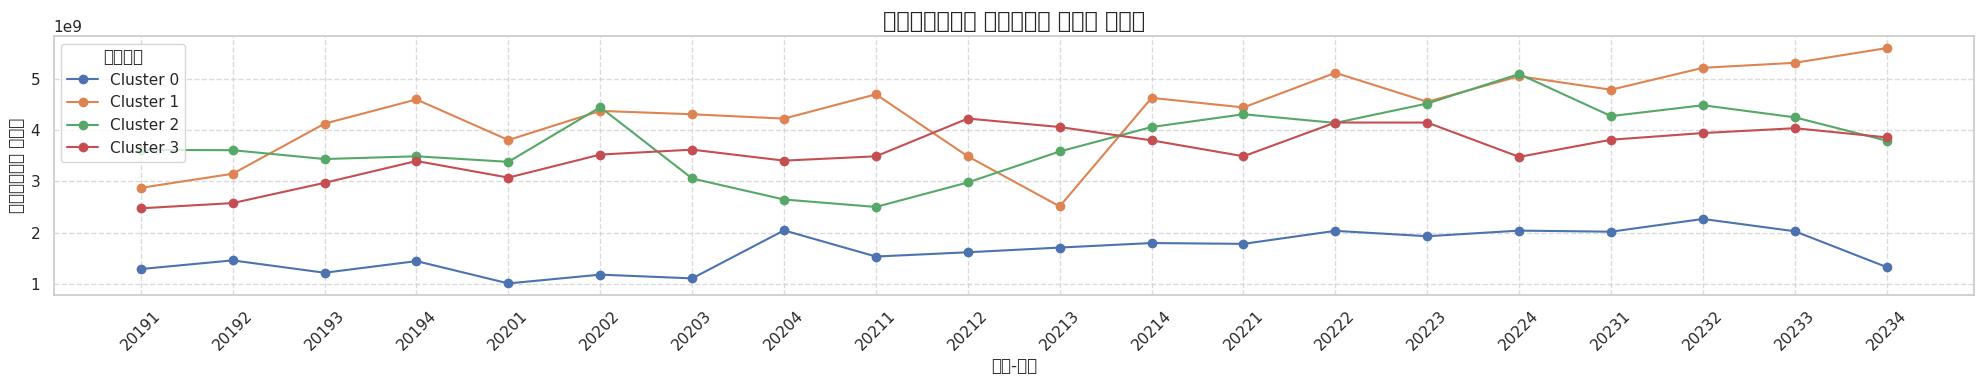

In [29]:
pivot = help_me_median(target_df, '당월매출금액')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

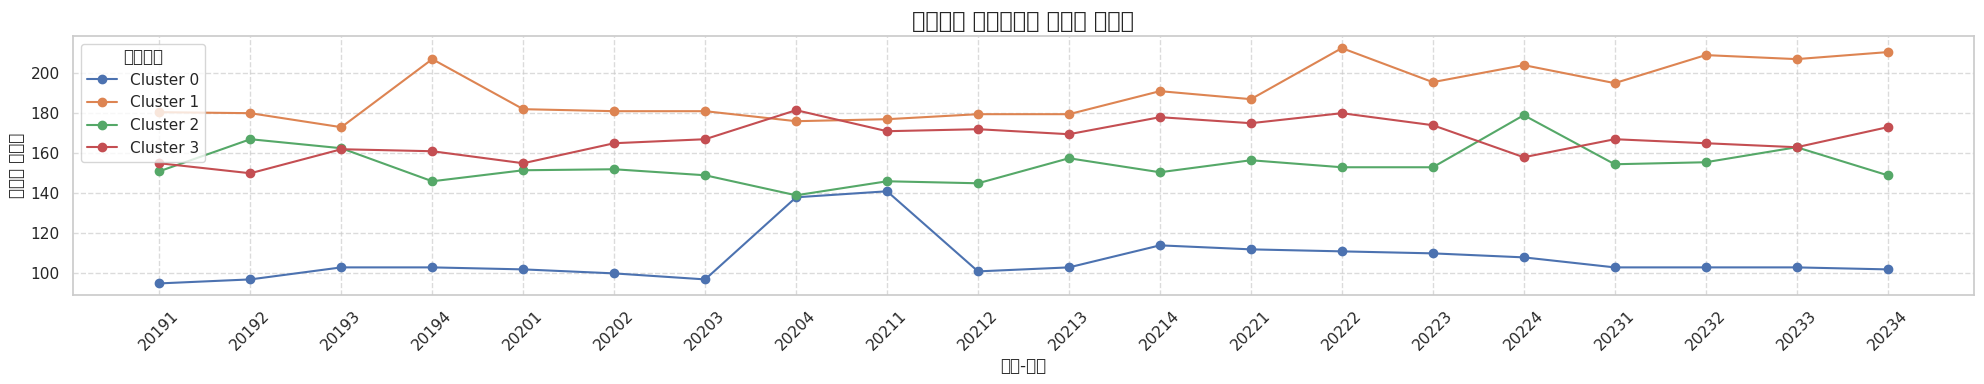

cluster  year quarter period      0      1      2      3
0        2019       1  20191   95.0  180.5  151.0  155.0
1        2019       2  20192   97.0  180.0  167.0  150.0
2        2019       3  20193  103.0  173.0  162.5  162.0
3        2019       4  20194  103.0  207.0  146.0  161.0
4        2020       1  20201  102.0  182.0  151.5  155.0
5        2020       2  20202  100.0  181.0  152.0  165.0
6        2020       3  20203   97.0  181.0  149.0  167.0
7        2020       4  20204  138.0  176.0  139.0  181.5
8        2021       1  20211  141.0  177.0  146.0  171.0
9        2021       2  20212  101.0  179.5  145.0  172.0
10       2021       3  20213  103.0  179.5  157.5  169.5
11       2021       4  20214  114.0  191.0  150.5  178.0
12       2022       1  20221  112.0  187.0  156.5  175.0
13       2022       2  20222  111.0  212.5  153.0  180.0
14       2022       3  20223  110.0  195.5  153.0  174.0
15       2022       4  20224  108.0  204.0  179.0  158.0
16       2023       1  20231  103.0  195.0  154.5  167.0
17       2023       2  20232  103.0  209.0  155.5  165.0
18       2023       3  20233  103.0  207.0  163.0  163.0
19       2023       4  20234  102.0  210.5  149.0  173.0

In [30]:
help_me_median(target_df, '점포수')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

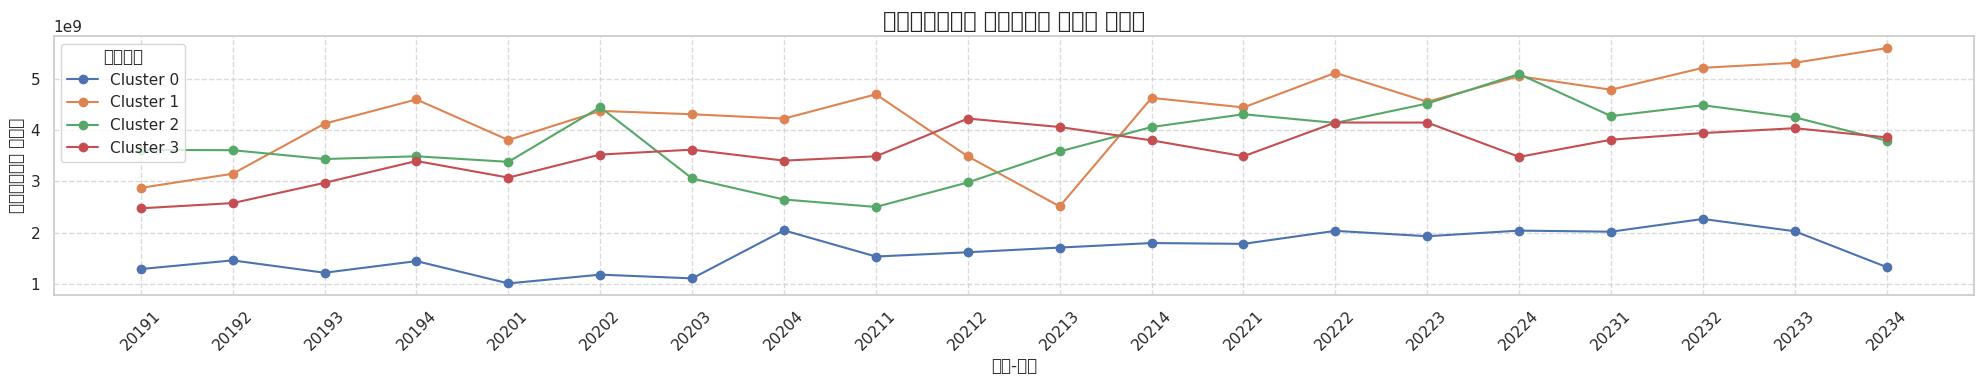

cluster  year quarter period             0             1             2  \
0        2019       1  20191  1.285645e+09  2.874888e+09  3.617843e+09   
1        2019       2  20192  1.455067e+09  3.150661e+09  3.611936e+09   
2        2019       3  20193  1.213193e+09  4.131622e+09  3.438897e+09   
3        2019       4  20194  1.440831e+09  4.604955e+09  3.492555e+09   
4        2020       1  20201  1.004358e+09  3.810483e+09  3.383773e+09   
5        2020       2  20202  1.176143e+09  4.381155e+09  4.453829e+09   
6        2020       3  20203  1.102612e+09  4.315001e+09  3.057945e+09   
7        2020       4  20204  2.042429e+09  4.230068e+09  2.646539e+09   
8        2021       1  20211  1.530245e+09  4.705196e+09  2.501157e+09   
9        2021       2  20212  1.613848e+09  3.491185e+09  2.980651e+09   
10       2021       3  20213  1.705866e+09  2.511473e+09  3.586827e+09   
11       2021       4  20214  1.794598e+09  4.636275e+09  4.065104e+09   
12       2022       1  20221  1.778436e+09  4.448574e+09  4.315599e+09   
13       2022       2  20222  2.033214e+09  5.126348e+09  4.145620e+09   
14       2022       3  20223  1.927614e+09  4.558651e+09  4.525504e+09   
15       2022       4  20224  2.037846e+09  5.060029e+09  5.103400e+09   
16       2023       1  20231  2.016385e+09  4.795225e+09  4.279291e+09   
17       2023       2  20232  2.265864e+09  5.224476e+09  4.491848e+09   
18       2023       3  20233  2.024928e+09  5.322481e+09  4.254850e+09   
19       2023       4  20234  1.323746e+09  5.610266e+09  3.797210e+09   

cluster             3  
0        2.474270e+09  
1        2.576594e+09  
2        2.973345e+09  
3        3.400274e+09  
4        3.075220e+09  
5        3.526059e+09  
6        3.622388e+09  
7        3.407693e+09  
8        3.492259e+09  
9        4.231131e+09  
10       4.065591e+09  
11       3.804247e+09  
12       3.493302e+09  
13       4.153530e+09  
14       4.152521e+09  
15       3.481001e+09  
16       3.816983e+09  
17       3.947327e+09  
18       4.042066e+09  
19       3.862999e+09

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

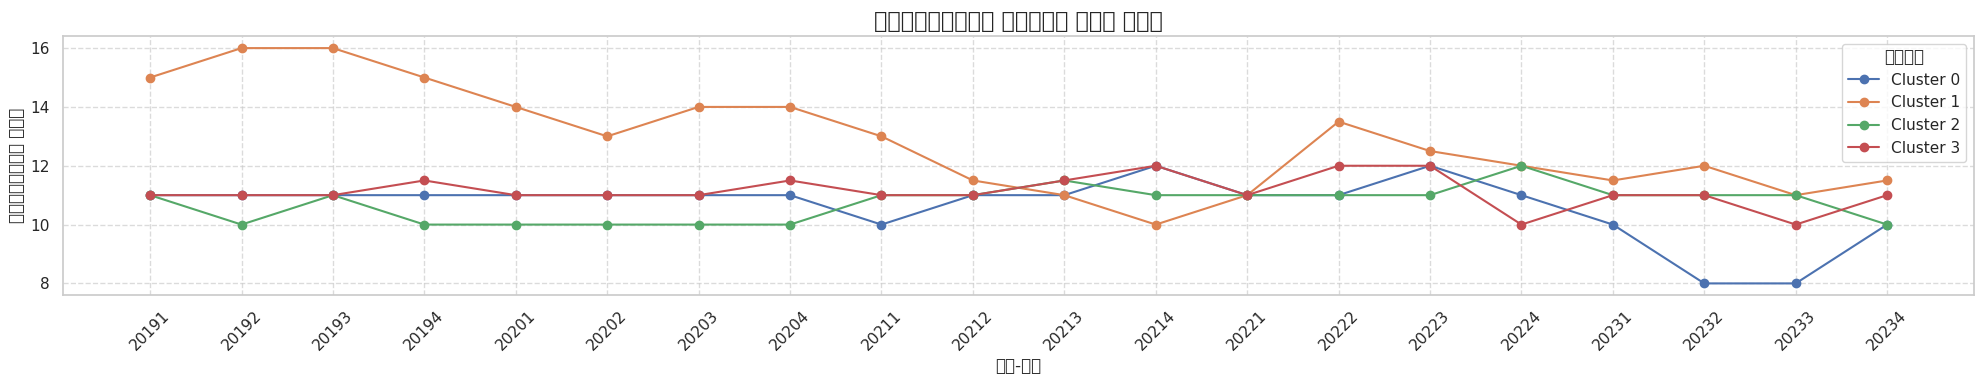

cluster  year quarter period     0     1     2     3
0        2019       1  20191  11.0  15.0  11.0  11.0
1        2019       2  20192  11.0  16.0  10.0  11.0
2        2019       3  20193  11.0  16.0  11.0  11.0
3        2019       4  20194  11.0  15.0  10.0  11.5
4        2020       1  20201  11.0  14.0  10.0  11.0
5        2020       2  20202  11.0  13.0  10.0  11.0
6        2020       3  20203  11.0  14.0  10.0  11.0
7        2020       4  20204  11.0  14.0  10.0  11.5
8        2021       1  20211  10.0  13.0  11.0  11.0
9        2021       2  20212  11.0  11.5  11.0  11.0
10       2021       3  20213  11.0  11.0  11.5  11.5
11       2021       4  20214  12.0  10.0  11.0  12.0
12       2022       1  20221  11.0  11.0  11.0  11.0
13       2022       2  20222  11.0  13.5  11.0  12.0
14       2022       3  20223  12.0  12.5  11.0  12.0
15       2022       4  20224  11.0  12.0  12.0  10.0
16       2023       1  20231  10.0  11.5  11.0  11.0
17       2023       2  20232   8.0  12.0  11.0  11.0
18       2023       3  20233   8.0  11.0  11.0  10.0
19       2023       4  20234  10.0  11.5  10.0  11.0

In [31]:
display(help_me_median(target_df, '당월매출금액'))
display(help_me_median(target_df, '프랜차이즈점포수'))

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

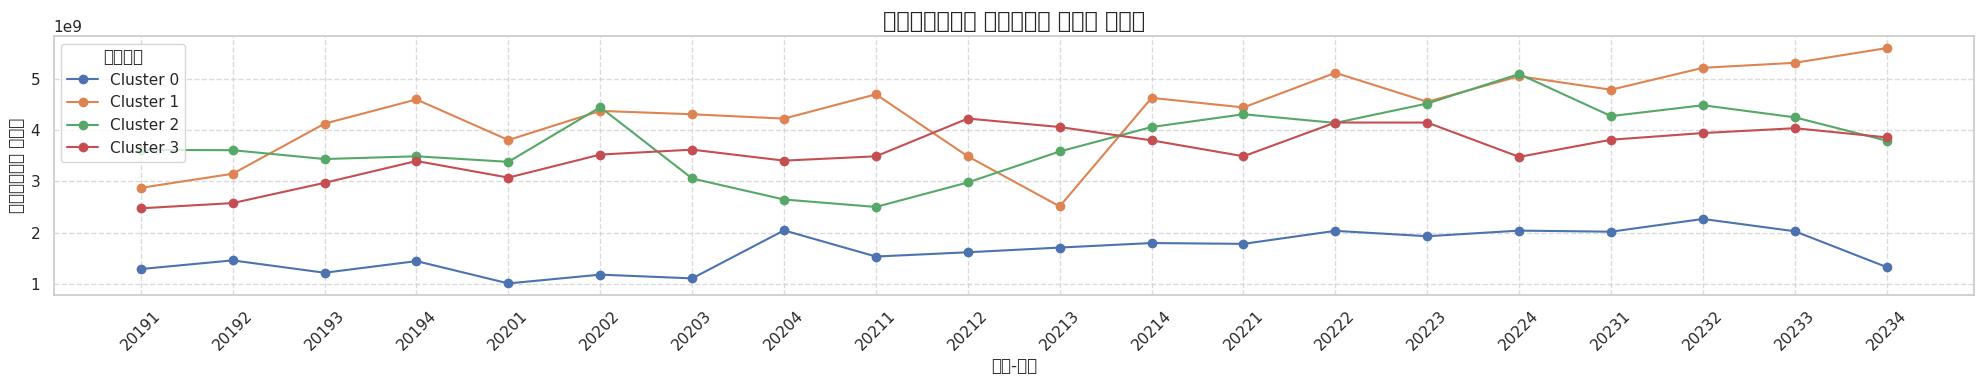

cluster  year quarter period             0             1             2  \
0        2019       1  20191  1.285645e+09  2.874888e+09  3.617843e+09   
1        2019       2  20192  1.455067e+09  3.150661e+09  3.611936e+09   
2        2019       3  20193  1.213193e+09  4.131622e+09  3.438897e+09   
3        2019       4  20194  1.440831e+09  4.604955e+09  3.492555e+09   
4        2020       1  20201  1.004358e+09  3.810483e+09  3.383773e+09   
5        2020       2  20202  1.176143e+09  4.381155e+09  4.453829e+09   
6        2020       3  20203  1.102612e+09  4.315001e+09  3.057945e+09   
7        2020       4  20204  2.042429e+09  4.230068e+09  2.646539e+09   
8        2021       1  20211  1.530245e+09  4.705196e+09  2.501157e+09   
9        2021       2  20212  1.613848e+09  3.491185e+09  2.980651e+09   
10       2021       3  20213  1.705866e+09  2.511473e+09  3.586827e+09   
11       2021       4  20214  1.794598e+09  4.636275e+09  4.065104e+09   
12       2022       1  20221  1.778436e+09  4.448574e+09  4.315599e+09   
13       2022       2  20222  2.033214e+09  5.126348e+09  4.145620e+09   
14       2022       3  20223  1.927614e+09  4.558651e+09  4.525504e+09   
15       2022       4  20224  2.037846e+09  5.060029e+09  5.103400e+09   
16       2023       1  20231  2.016385e+09  4.795225e+09  4.279291e+09   
17       2023       2  20232  2.265864e+09  5.224476e+09  4.491848e+09   
18       2023       3  20233  2.024928e+09  5.322481e+09  4.254850e+09   
19       2023       4  20234  1.323746e+09  5.610266e+09  3.797210e+09   

cluster             3  
0        2.474270e+09  
1        2.576594e+09  
2        2.973345e+09  
3        3.400274e+09  
4        3.075220e+09  
5        3.526059e+09  
6        3.622388e+09  
7        3.407693e+09  
8        3.492259e+09  
9        4.231131e+09  
10       4.065591e+09  
11       3.804247e+09  
12       3.493302e+09  
13       4.153530e+09  
14       4.152521e+09  
15       3.481001e+09  
16       3.816983e+09  
17       3.947327e+09  
18       4.042066e+09  
19       3.862999e+09

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

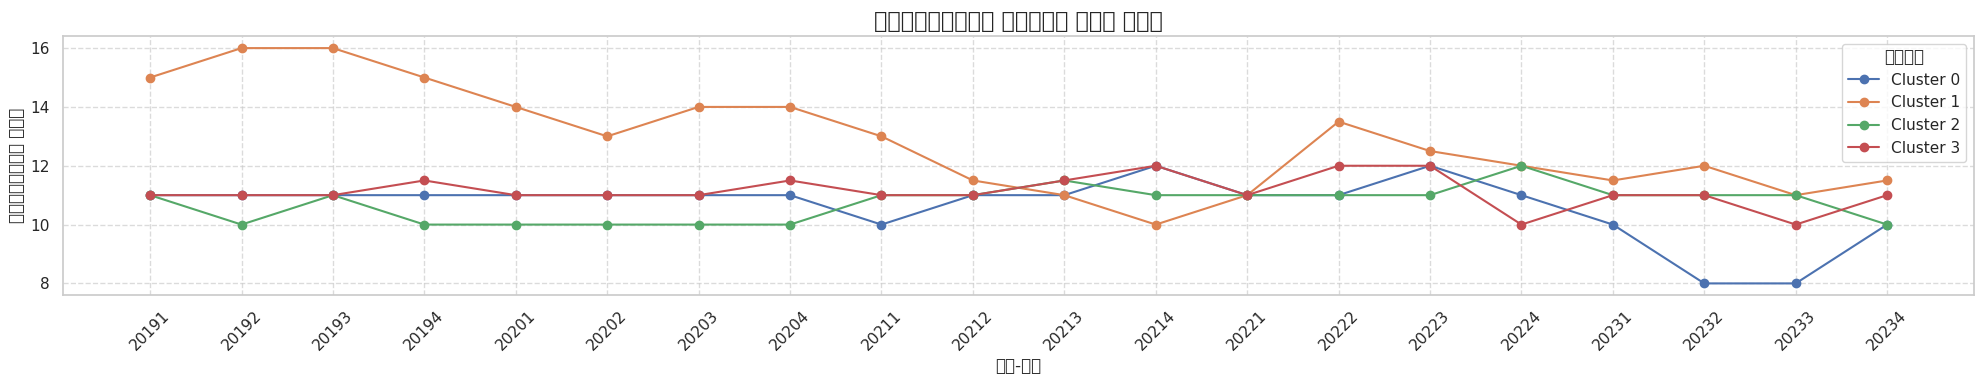

cluster  year quarter period     0     1     2     3
0        2019       1  20191  11.0  15.0  11.0  11.0
1        2019       2  20192  11.0  16.0  10.0  11.0
2        2019       3  20193  11.0  16.0  11.0  11.0
3        2019       4  20194  11.0  15.0  10.0  11.5
4        2020       1  20201  11.0  14.0  10.0  11.0
5        2020       2  20202  11.0  13.0  10.0  11.0
6        2020       3  20203  11.0  14.0  10.0  11.0
7        2020       4  20204  11.0  14.0  10.0  11.5
8        2021       1  20211  10.0  13.0  11.0  11.0
9        2021       2  20212  11.0  11.5  11.0  11.0
10       2021       3  20213  11.0  11.0  11.5  11.5
11       2021       4  20214  12.0  10.0  11.0  12.0
12       2022       1  20221  11.0  11.0  11.0  11.0
13       2022       2  20222  11.0  13.5  11.0  12.0
14       2022       3  20223  12.0  12.5  11.0  12.0
15       2022       4  20224  11.0  12.0  12.0  10.0
16       2023       1  20231  10.0  11.5  11.0  11.0
17       2023       2  20232   8.0  12.0  11.0  11.0
18       2023       3  20233   8.0  11.0  11.0  10.0
19       2023       4  20234  10.0  11.5  10.0  11.0

In [32]:
display(help_me_median(target_df, '당월매출금액'))
display(help_me_median(target_df, '프랜차이즈점포수'))

In [33]:
print(target_df.columns.tolist())

['상권구분코드', '상권구분', '상권코드', '상권', 'x좌표', 'y좌표', '자치구코드', '자치구', '행정동코드', '행정동', '영역면적', '20191점포수', '20192점포수', '20193점포수', '20194점포수', '20201점포수', '20202점포수', '20203점포수', '20204점포수', '20211점포수', '20212점포수', '20213점포수', '20214점포수', '20221점포수', '20222점포수', '20223점포수', '20224점포수', '20231점포수', '20232점포수', '20233점포수', '20234점포수', '20191유사업종점포수', '20192유사업종점포수', '20193유사업종점포수', '20194유사업종점포수', '20201유사업종점포수', '20202유사업종점포수', '20203유사업종점포수', '20204유사업종점포수', '20211유사업종점포수', '20212유사업종점포수', '20213유사업종점포수', '20214유사업종점포수', '20221유사업종점포수', '20222유사업종점포수', '20223유사업종점포수', '20224유사업종점포수', '20231유사업종점포수', '20232유사업종점포수', '20233유사업종점포수', '20234유사업종점포수', '20191개업점포수', '20192개업점포수', '20193개업점포수', '20194개업점포수', '20201개업점포수', '20202개업점포수', '20203개업점포수', '20204개업점포수', '20211개업점포수', '20212개업점포수', '20213개업점포수', '20214개업점포수', '20221개업점포수', '20222개업점포수', '20223개업점포수', '20224개업점포수', '20231개업점포수', '20232개업점포수', '20233개업점포수', '20234개업점포수', '20191폐업점포수', '20192폐업점포수', '20193폐업점포수', '20194폐업점포수', '20201폐업점포수', '20

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

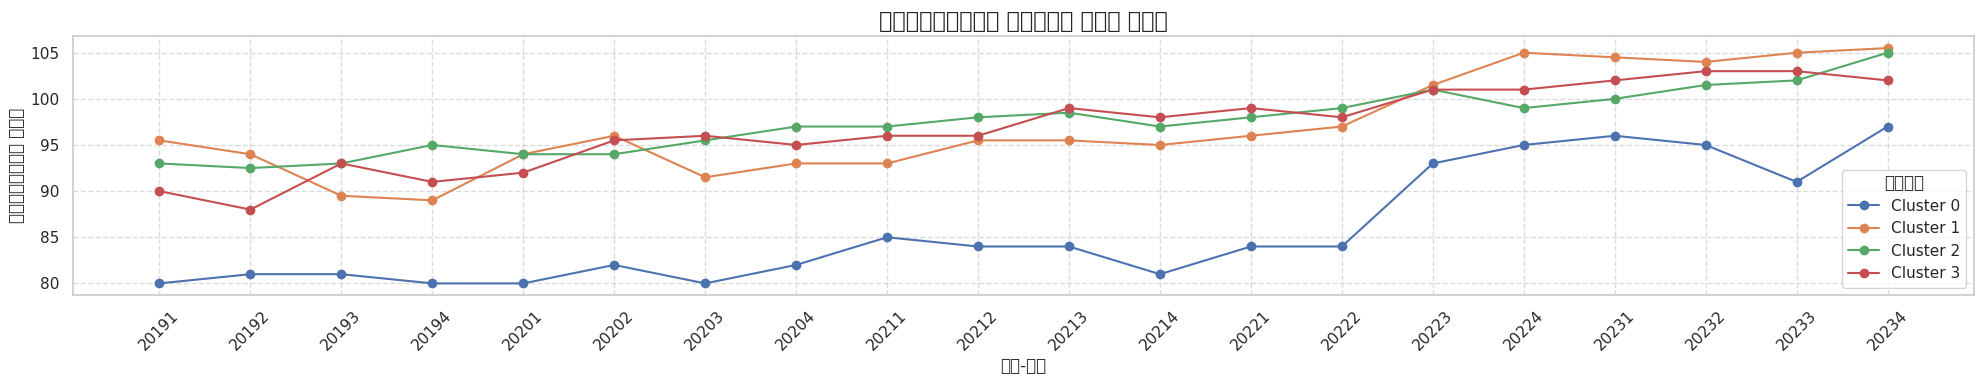

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

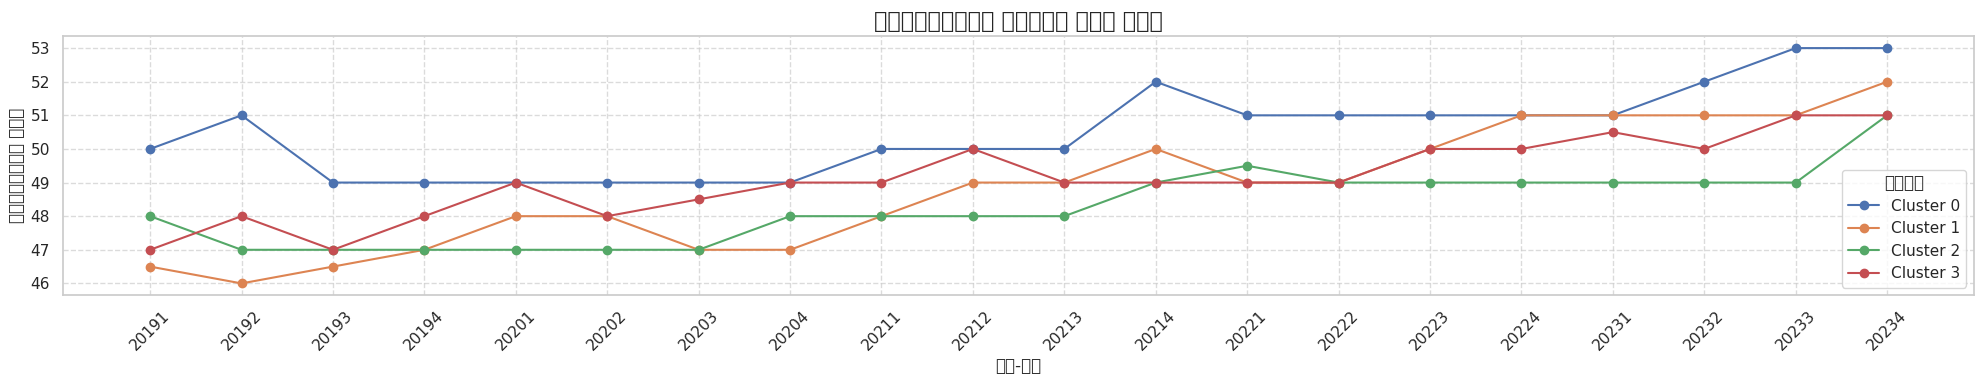

In [34]:
pivot = help_me_median(target_df, '운영영업개월평균')
pivot = help_me_median(target_df, '폐업영업개월평균')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

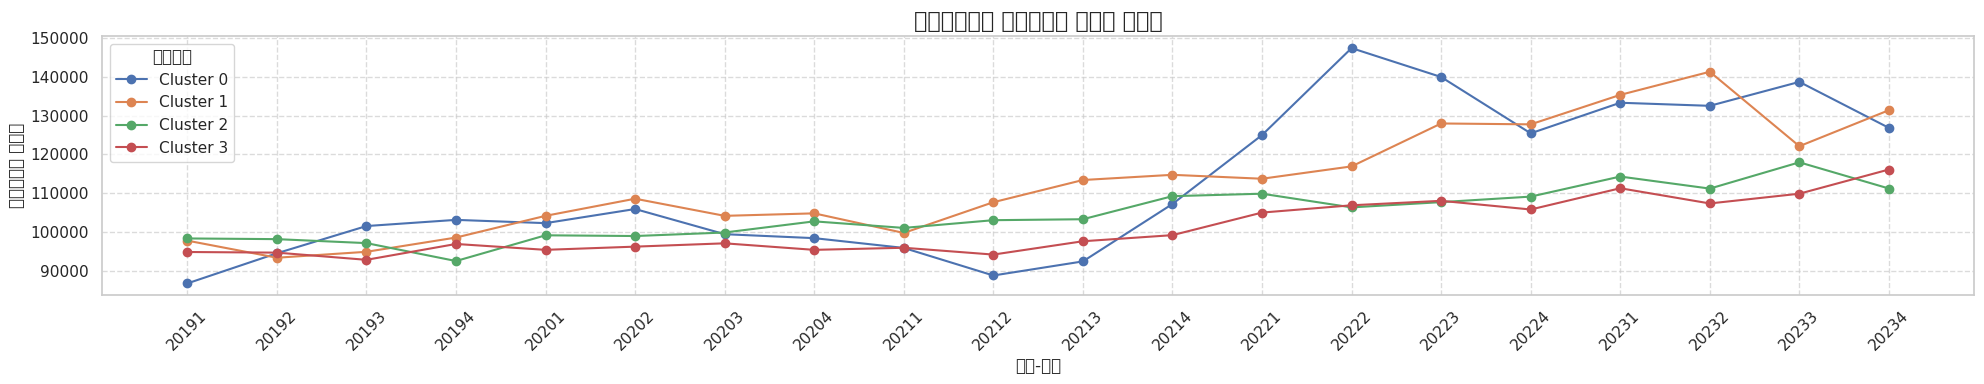

cluster  year quarter period         0         1         2         3
0        2019       1  20191   86823.0   97826.5   98388.0   94903.0
1        2019       2  20192   94573.0   93430.0   98211.0   94740.0
2        2019       3  20193  101579.0   94953.0   97188.0   92890.5
3        2019       4  20194  103167.0   98620.0   92579.0   96968.5
4        2020       1  20201  102327.0  104208.0   99197.0   95457.0
5        2020       2  20202  105958.0  108611.0   99011.0   96281.0
6        2020       3  20203   99483.0  104203.0   99918.0   97134.5
7        2020       4  20204   98466.0  104844.0  102785.0   95454.0
8        2021       1  20211   95949.0   99802.0  101099.0   95993.0
9        2021       2  20212   88859.0  107709.0  103085.0   94239.0
10       2021       3  20213   92485.0  113419.5  103331.5   97667.5
11       2021       4  20214  107253.0  114756.0  109265.0   99237.0
12       2022       1  20221  124983.0  113749.5  109898.0  105044.0
13       2022       2  20222  147355.0  116924.0  106379.0  106918.0
14       2022       3  20223  139918.0  127967.0  107732.0  108069.0
15       2022       4  20224  125431.0  127740.0  109151.0  105836.0
16       2023       1  20231  133297.0  135322.0  114313.0  111305.0
17       2023       2  20232  132505.0  141268.0  111212.5  107392.0
18       2023       3  20233  138664.0  122119.0  117972.5  109899.0
19       2023       4  20234  126834.5  131382.0  111232.0  116123.0

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

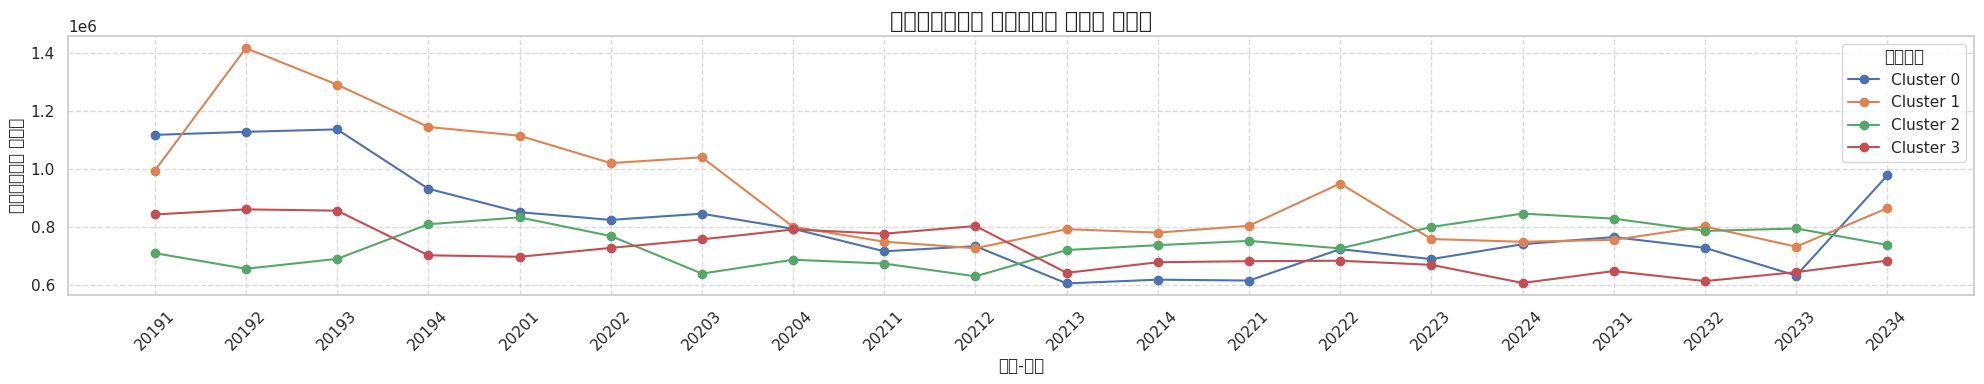

cluster  year quarter period          0          1         2         3
0        2019       1  20191  1116723.0   993240.5  708318.0  841845.0
1        2019       2  20192  1127217.0  1416431.0  654442.0  859480.0
2        2019       3  20193  1135702.0  1290194.5  688481.5  855025.5
3        2019       4  20194   930607.0  1143904.0  808063.0  700845.5
4        2020       1  20201   849686.0  1113872.0  831805.0  695718.0
5        2020       2  20202   823142.0  1019317.0  767537.0  726301.0
6        2020       3  20203   844514.0  1039230.0  637665.0  755806.0
7        2020       4  20204   792336.0   799397.0  685556.0  789997.0
8        2021       1  20211   714615.0   747804.0  672241.0  775462.5
9        2021       2  20212   732440.0   725248.5  628285.0  802019.0
10       2021       3  20213   603782.0   791016.0  719108.5  640272.0
11       2021       4  20214   616703.0   779262.0  735872.0  676833.0
12       2022       1  20221   613576.0   802882.5  750705.5  680608.0
13       2022       2  20222   722142.0   948798.0  724580.0  682117.0
14       2022       3  20223   687604.0   756991.5  798758.0  667907.0
15       2022       4  20224   739152.0   747631.0  844910.5  605312.0
16       2023       1  20231   763781.0   754103.0  827378.0  646410.0
17       2023       2  20232   726647.0   800323.0  784917.5  611701.0
18       2023       3  20233   630665.0   730636.0  793440.0  642841.0
19       2023       4  20234   976916.5   863633.5  736492.5  682460.0

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

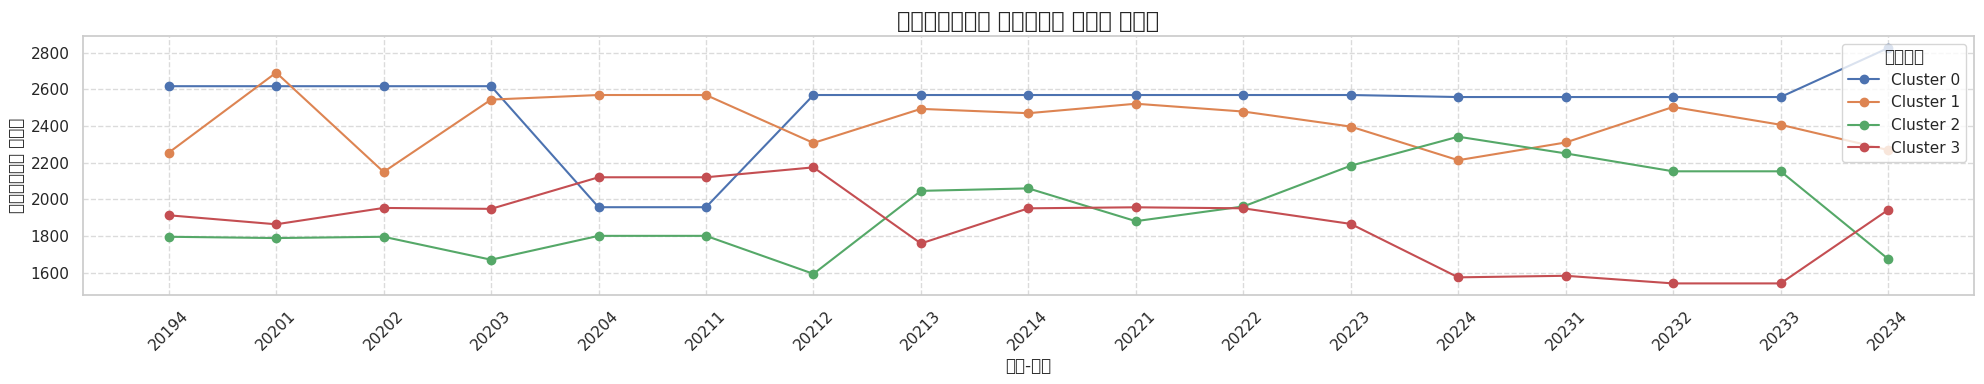

cluster  year quarter period       0       1       2       3
0        2019       4  20194  2617.0  2255.0  1797.0  1914.0
1        2020       1  20201  2617.0  2691.0  1790.0  1865.0
2        2020       2  20202  2617.0  2150.0  1797.0  1954.0
3        2020       3  20203  2617.0  2544.0  1672.0  1949.0
4        2020       4  20204  1958.0  2569.0  1802.0  2121.0
5        2021       1  20211  1958.0  2569.0  1802.0  2121.0
6        2021       2  20212  2569.0  2308.0  1595.0  2175.0
7        2021       3  20213  2569.0  2493.5  2047.0  1760.5
8        2021       4  20214  2569.0  2470.0  2060.5  1952.0
9        2022       1  20221  2569.0  2521.5  1882.0  1957.5
10       2022       2  20222  2569.0  2479.0  1962.0  1952.0
11       2022       3  20223  2569.0  2397.0  2184.0  1867.0
12       2022       4  20224  2558.0  2214.0  2342.0  1576.0
13       2023       1  20231  2558.0  2310.5  2251.0  1584.5
14       2023       2  20232  2558.0  2504.0  2153.5  1543.0
15       2023       3  20233  2558.0  2407.0  2153.5  1543.0
16       2023       4  20234  2824.5  2269.5  1676.5  1943.0

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

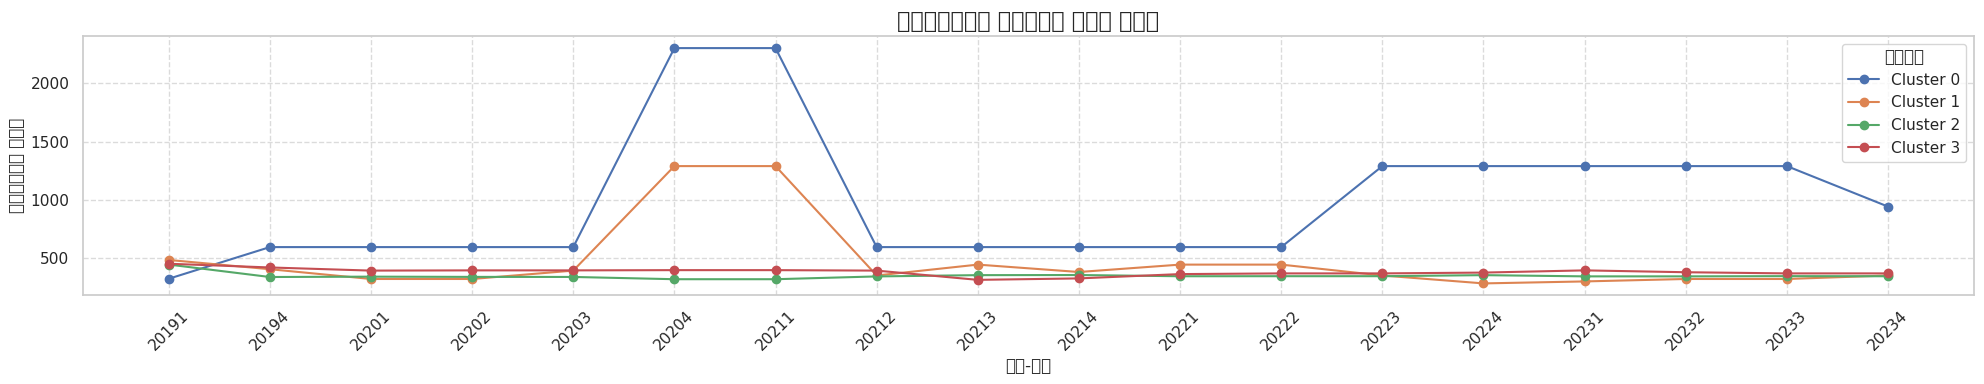

cluster  year quarter period       0       1      2      3
0        2019       1  20191   321.0   482.5  443.0  450.0
1        2019       4  20194   593.0   403.0  336.0  418.0
2        2020       1  20201   593.0   319.0  339.0  391.0
3        2020       2  20202   593.0   319.0  337.0  393.0
4        2020       3  20203   593.0   391.0  336.5  393.0
5        2020       4  20204  2303.0  1289.0  317.0  395.0
6        2021       1  20211  2303.0  1289.0  317.0  395.0
7        2021       2  20212   593.0   349.0  341.0  391.0
8        2021       3  20213   593.0   442.5  352.0  311.5
9        2021       4  20214   593.0   379.0  353.0  324.0
10       2022       1  20221   593.0   442.5  342.5  361.0
11       2022       2  20222   593.0   442.5  343.0  367.0
12       2022       3  20223  1289.0   349.0  343.0  367.0
13       2022       4  20224  1289.0   281.0  352.0  374.0
14       2023       1  20231  1289.0   298.0  341.5  393.0
15       2023       2  20232  1289.0   319.0  341.5  377.0
16       2023       3  20233  1289.0   319.0  343.5  367.0
17       2023       4  20234   941.0   349.0  342.5  367.0

In [35]:
# 0번 군집 기준 총 직장인구가 많음 -> 임대료 높음 -> 주거보단 직장에 관한 케이스가 더 큰거같음.
# 0 번 군집이 확실히 직장 인구수가 높은 경향이 있음. -> 가디나 구디 이런곳 제외하고.. 진짜 직장으로만 다니는 사람이 많은동내?
# 1번이 젠트리지역이 더 높다.
display(help_me_median(target_df, '총계임대료'))
display(help_me_median(target_df, '총유동인구수'))
display(help_me_median(target_df, '총상주인구수'))
display(help_me_median(target_df, '총직장인구수'))

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

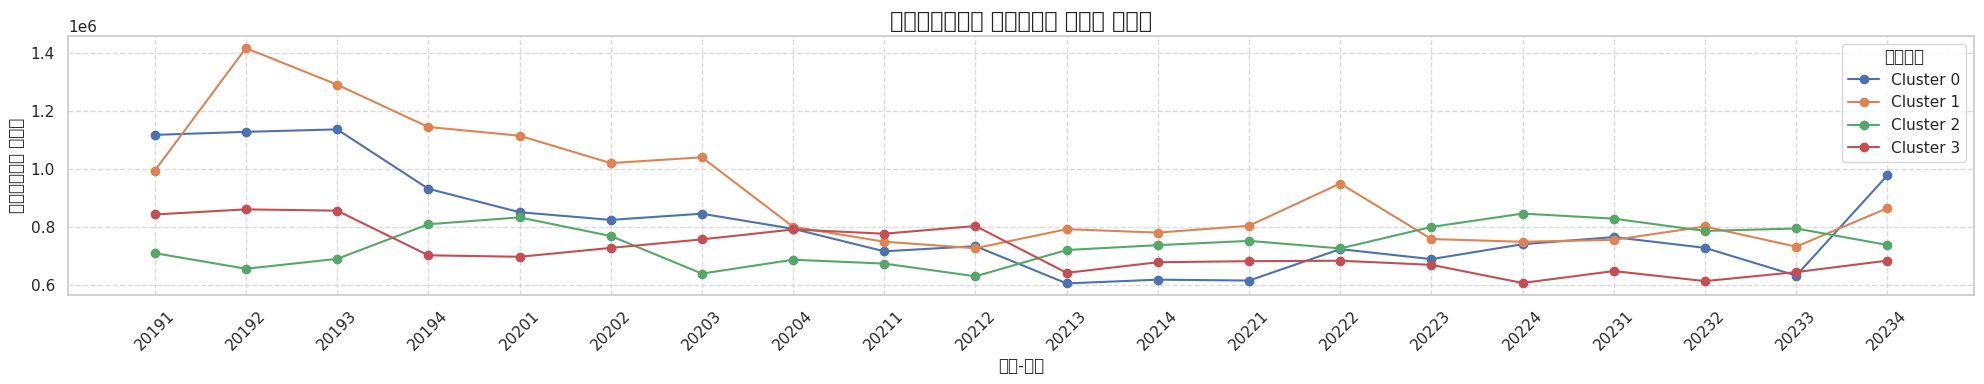

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

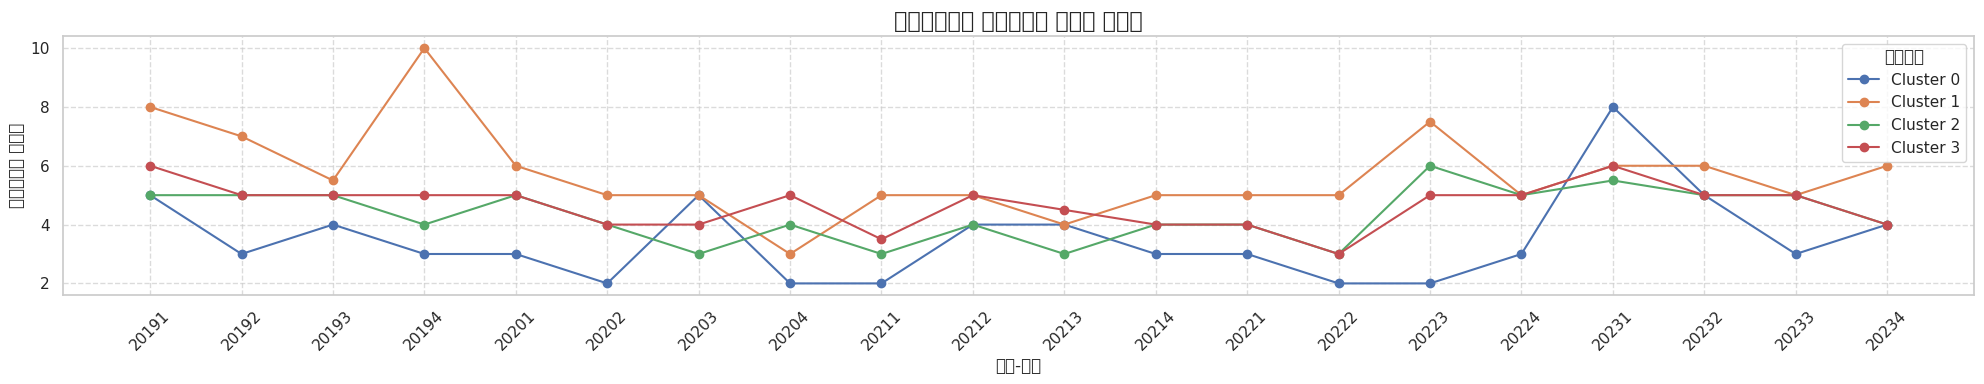

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

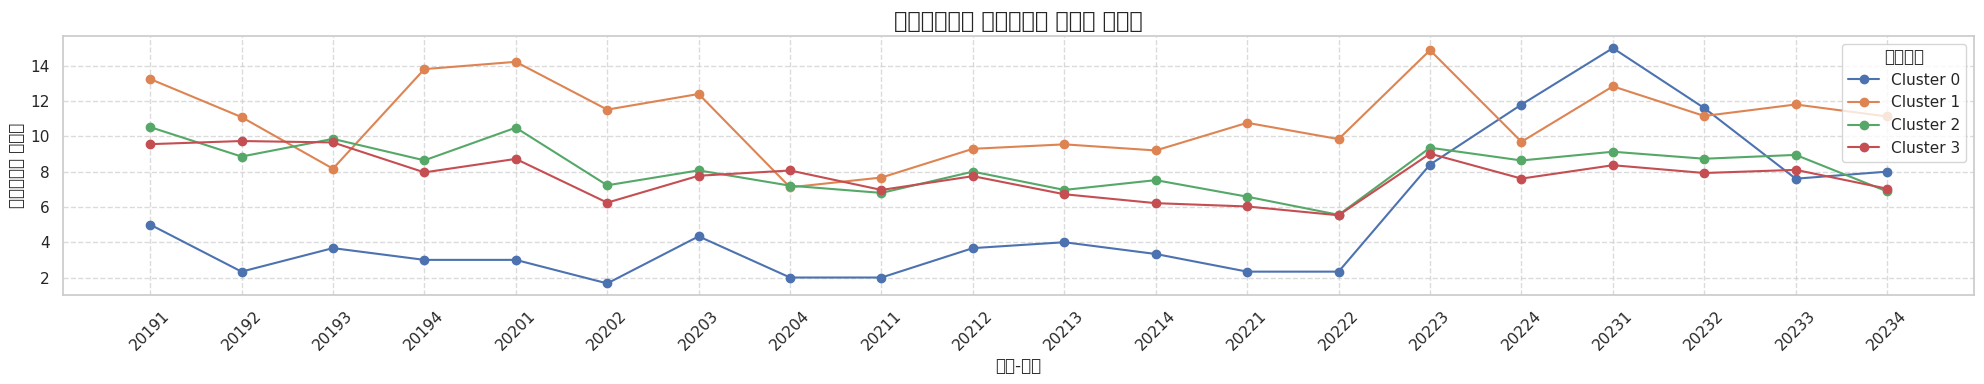

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

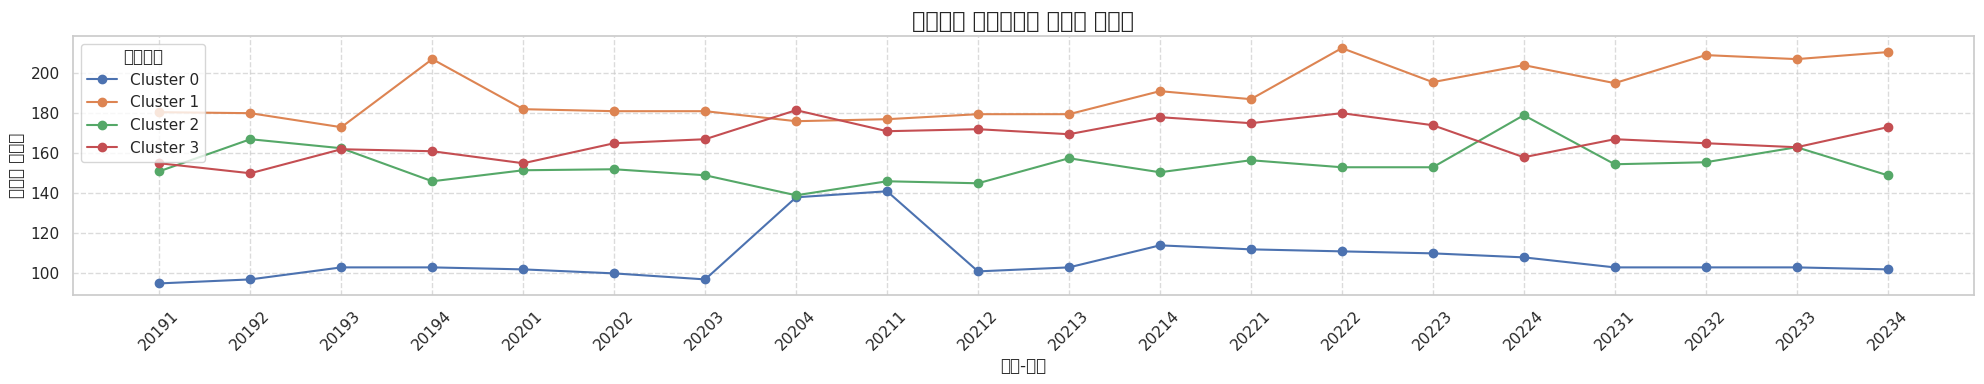

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

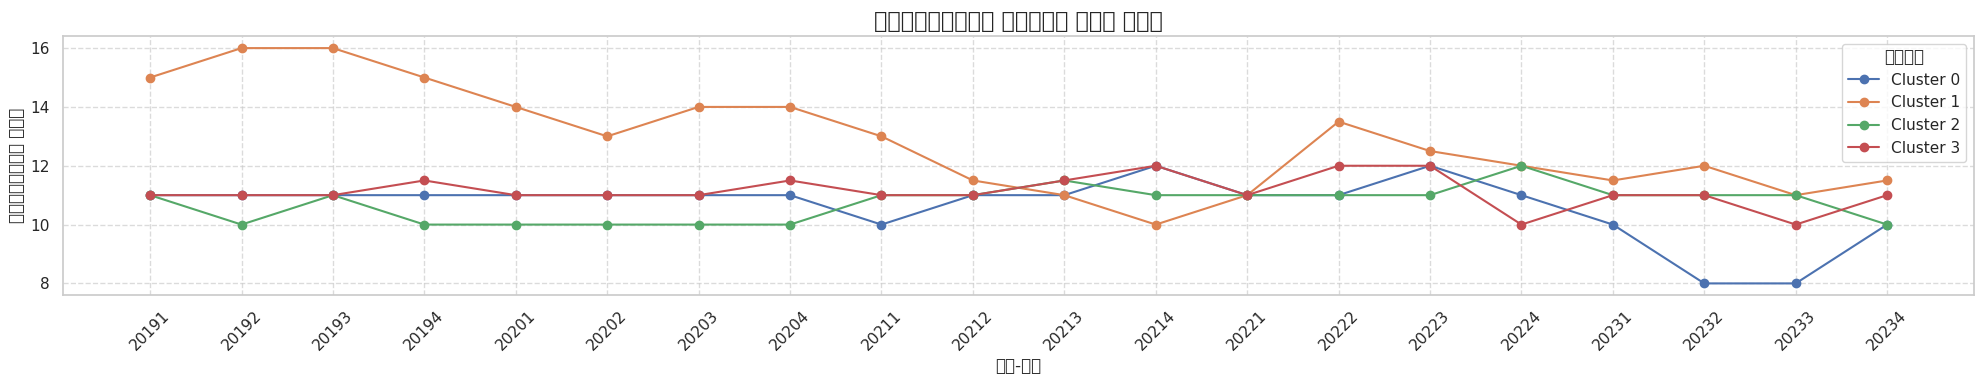

cluster  year quarter period     0     1     2     3
0        2019       1  20191  11.0  15.0  11.0  11.0
1        2019       2  20192  11.0  16.0  10.0  11.0
2        2019       3  20193  11.0  16.0  11.0  11.0
3        2019       4  20194  11.0  15.0  10.0  11.5
4        2020       1  20201  11.0  14.0  10.0  11.0
5        2020       2  20202  11.0  13.0  10.0  11.0
6        2020       3  20203  11.0  14.0  10.0  11.0
7        2020       4  20204  11.0  14.0  10.0  11.5
8        2021       1  20211  10.0  13.0  11.0  11.0
9        2021       2  20212  11.0  11.5  11.0  11.0
10       2021       3  20213  11.0  11.0  11.5  11.5
11       2021       4  20214  12.0  10.0  11.0  12.0
12       2022       1  20221  11.0  11.0  11.0  11.0
13       2022       2  20222  11.0  13.5  11.0  12.0
14       2022       3  20223  12.0  12.5  11.0  12.0
15       2022       4  20224  11.0  12.0  12.0  10.0
16       2023       1  20231  10.0  11.5  11.0  11.0
17       2023       2  20232   8.0  12.0  11.0  11.0
18       2023       3  20233   8.0  11.0  11.0  10.0
19       2023       4  20234  10.0  11.5  10.0  11.0

In [36]:
# 유동 + 점포 폐업 개업
pivot = help_me_median(target_df, '총유동인구수')
# pivot = help_me_median(target_df, '개업점포수')
pivot = help_me_median(target_df, '폐업점포수')
help_me_mean(target_df, '폐업점포수')
pivot = help_me_median(target_df, '점포수')
help_me_median(target_df, '프랜차이즈점포수')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

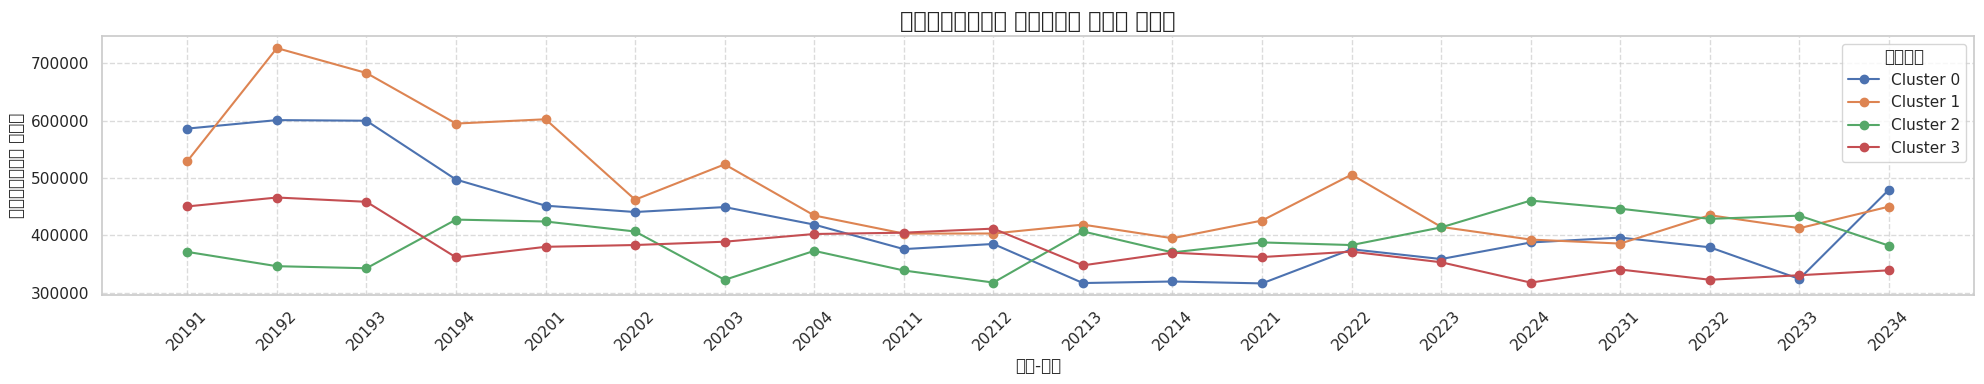

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

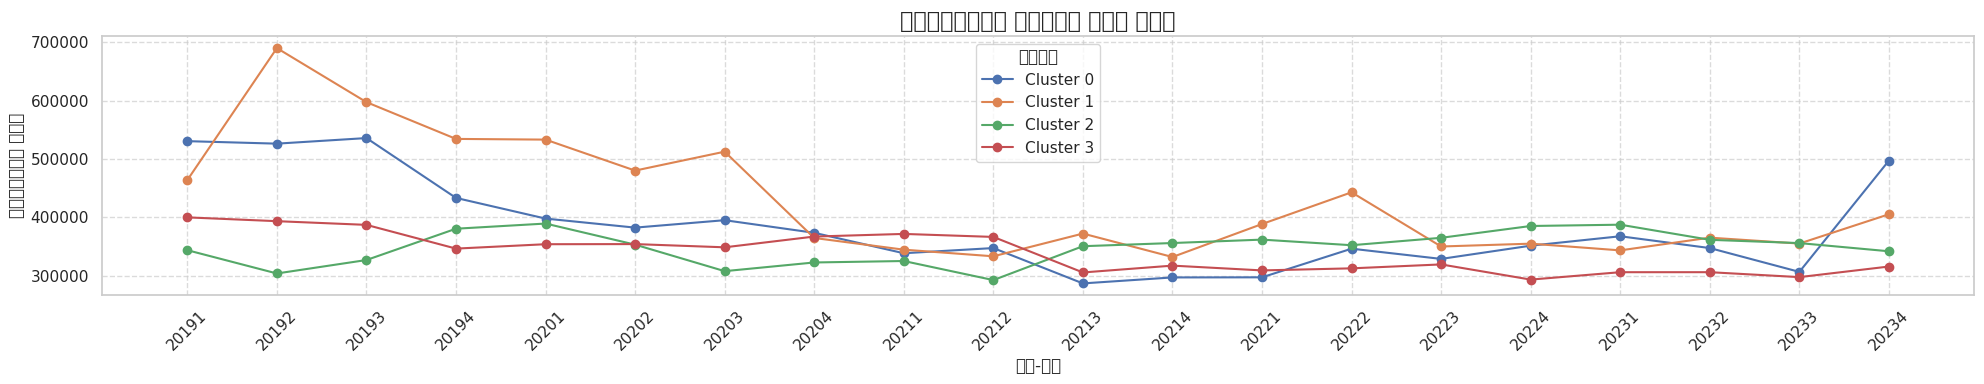

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

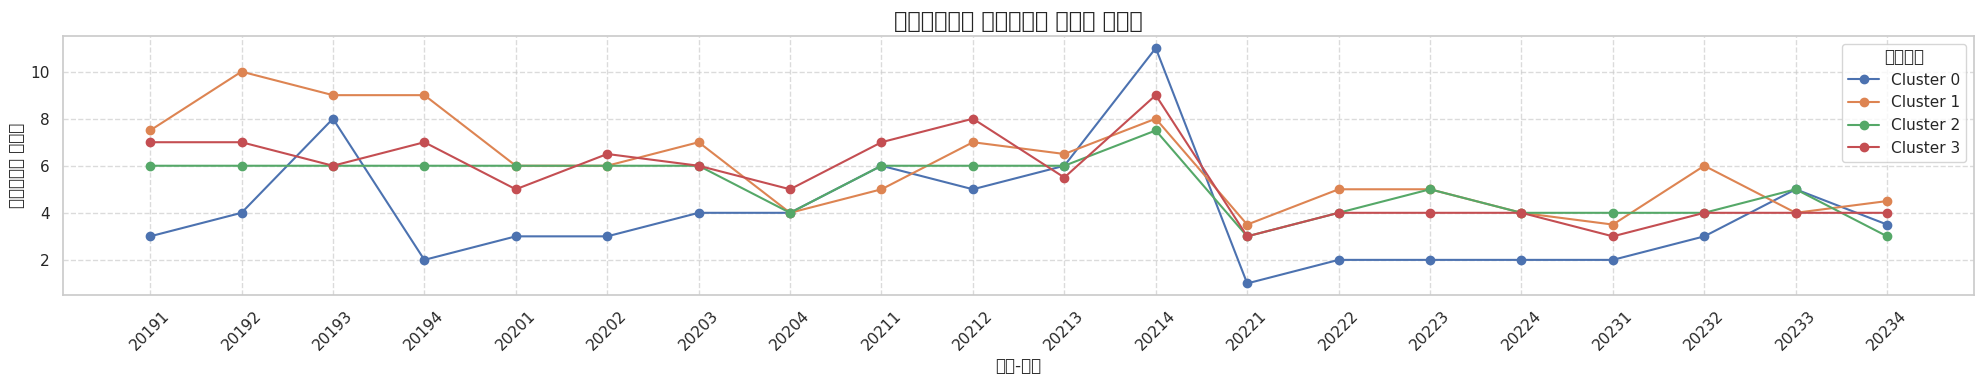

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

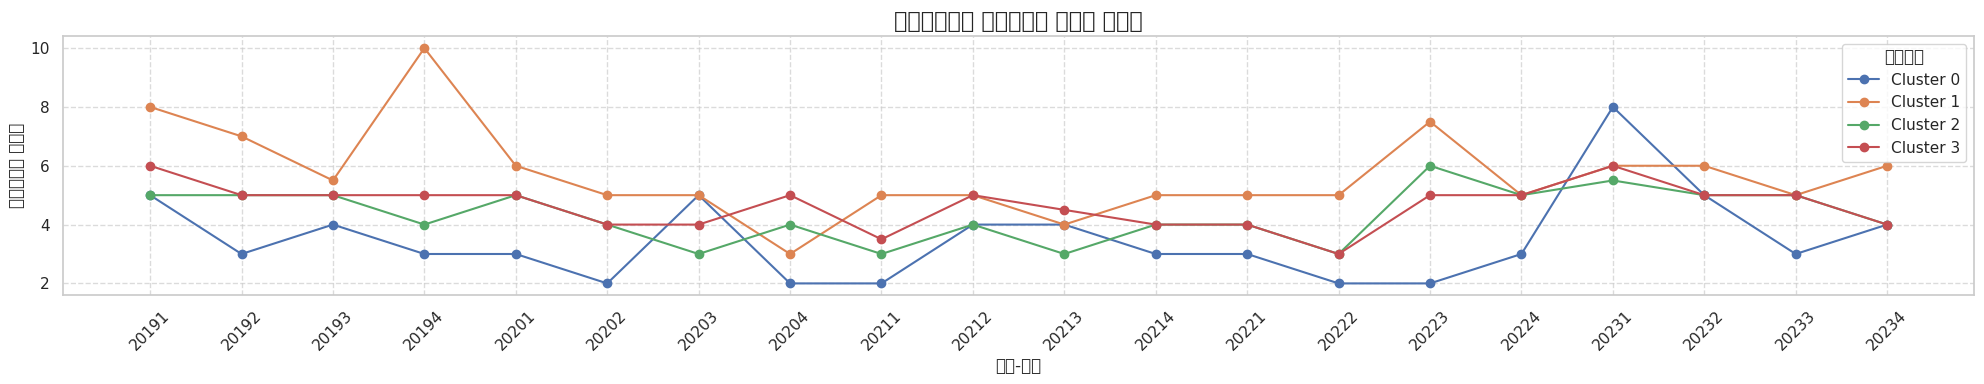

In [37]:
# 성별 + 폐업
pivot = help_me_median(target_df, '여성유동인구수')
pivot = help_me_median(target_df, '남성유동인구수')
pivot = help_me_median(target_df, '개업점포수')
pivot = help_me_median(target_df, '폐업점포수')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

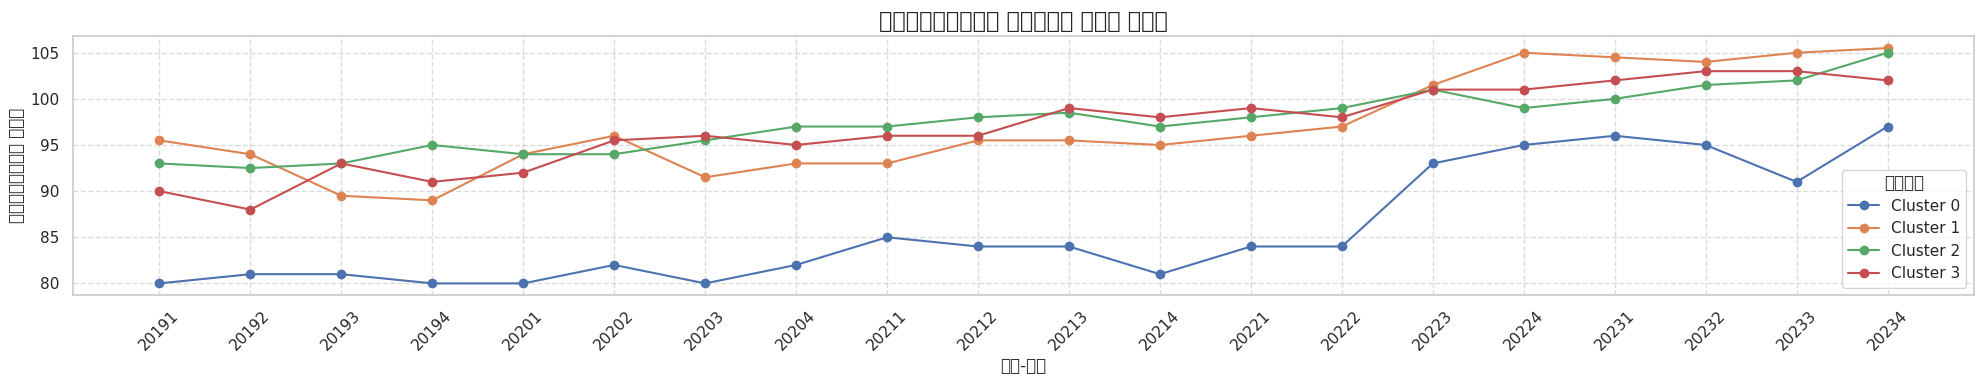

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

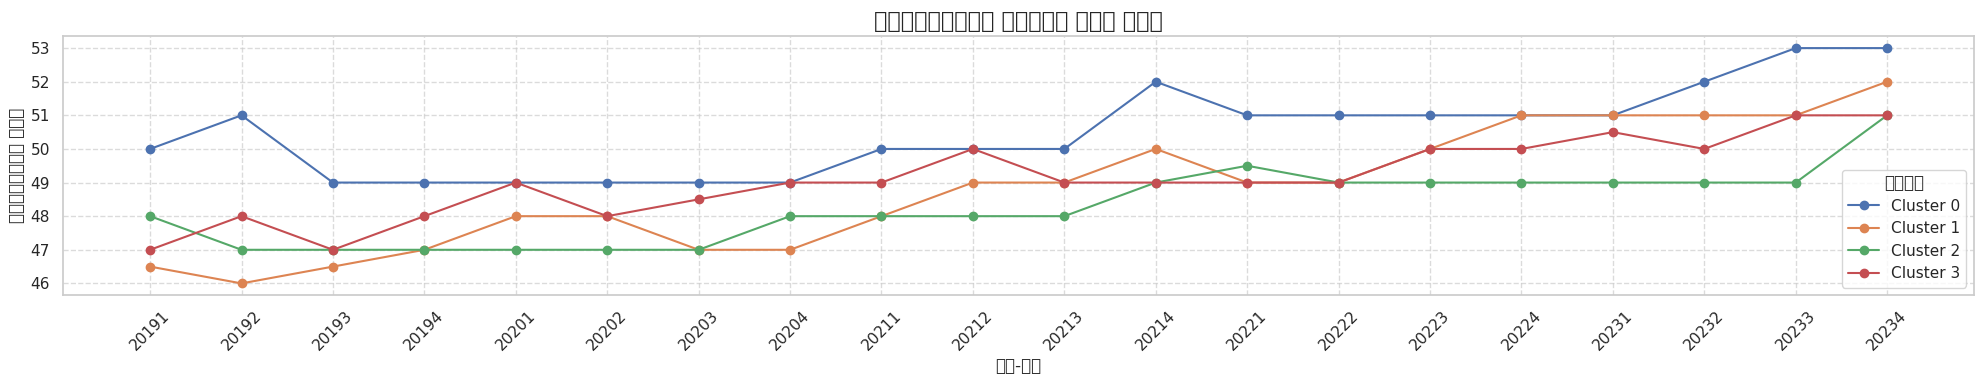

In [38]:
# 운영영업개월 + 폐업개월평균
pivot = help_me_median(target_df, '운영영업개월평균')
pivot = help_me_median(target_df, '폐업영업개월평균')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

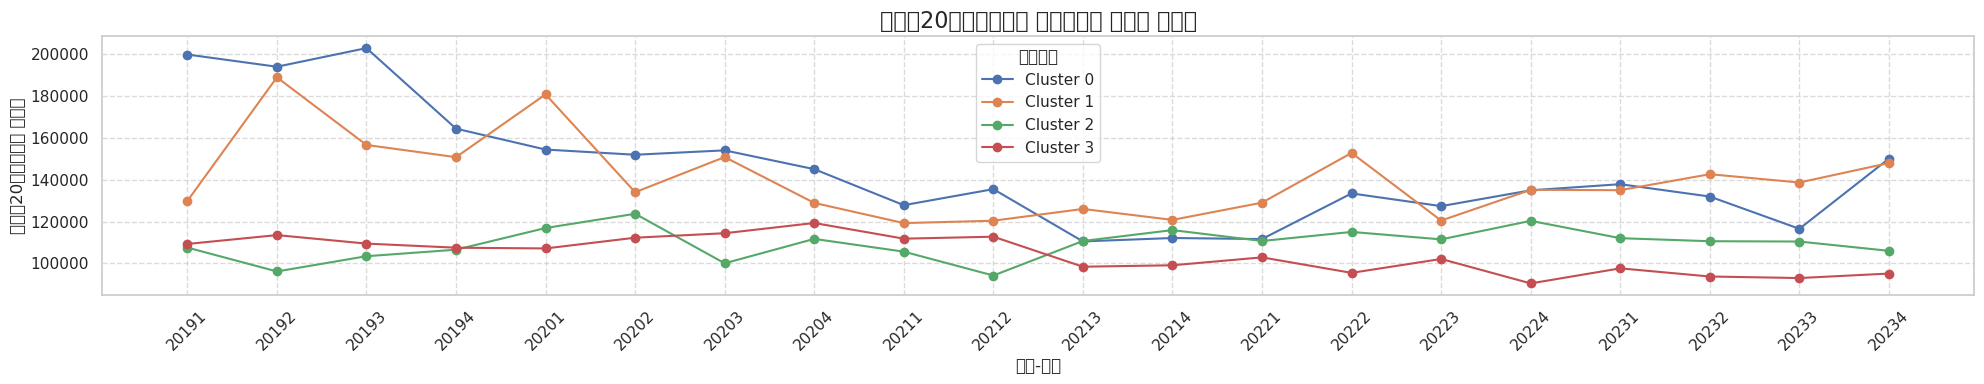

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

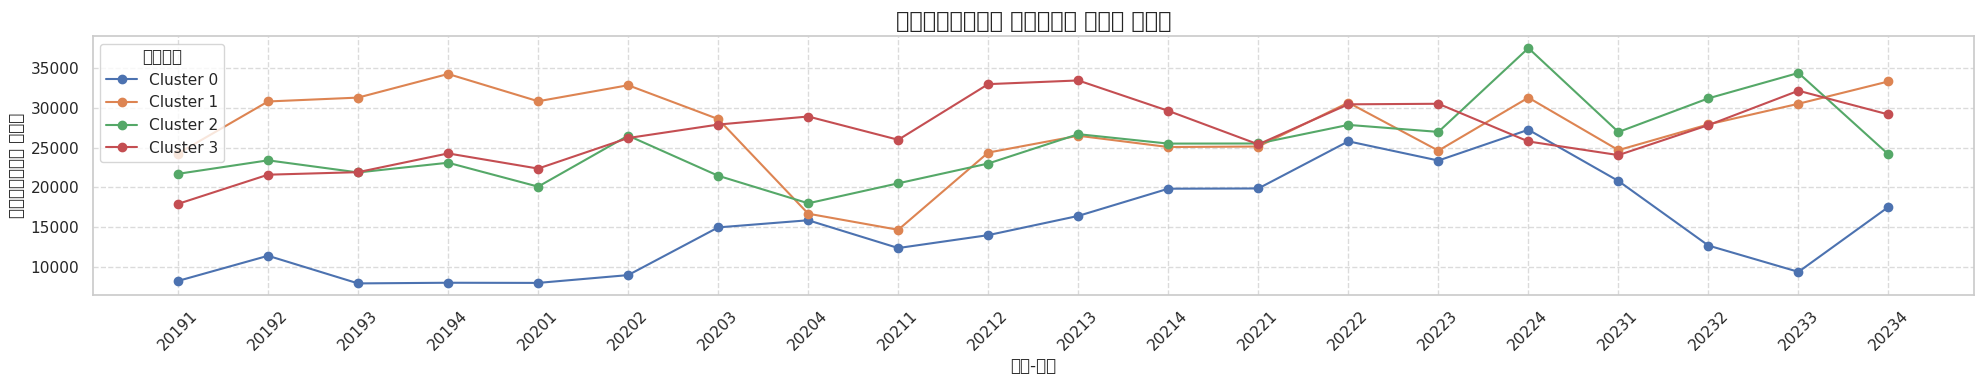

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

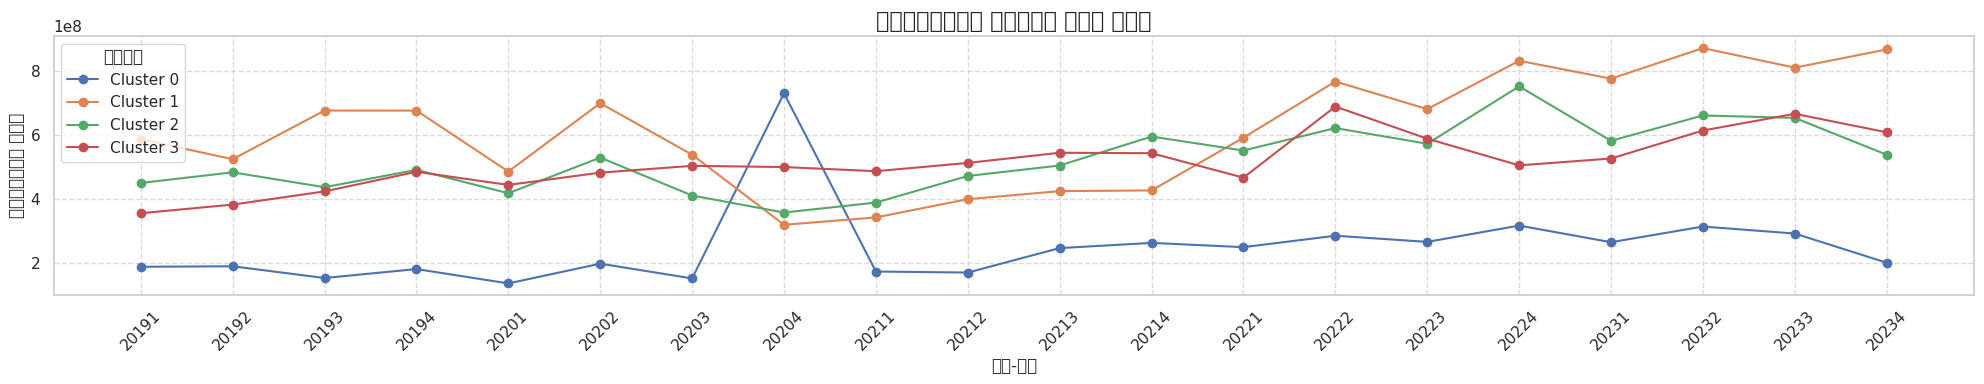

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

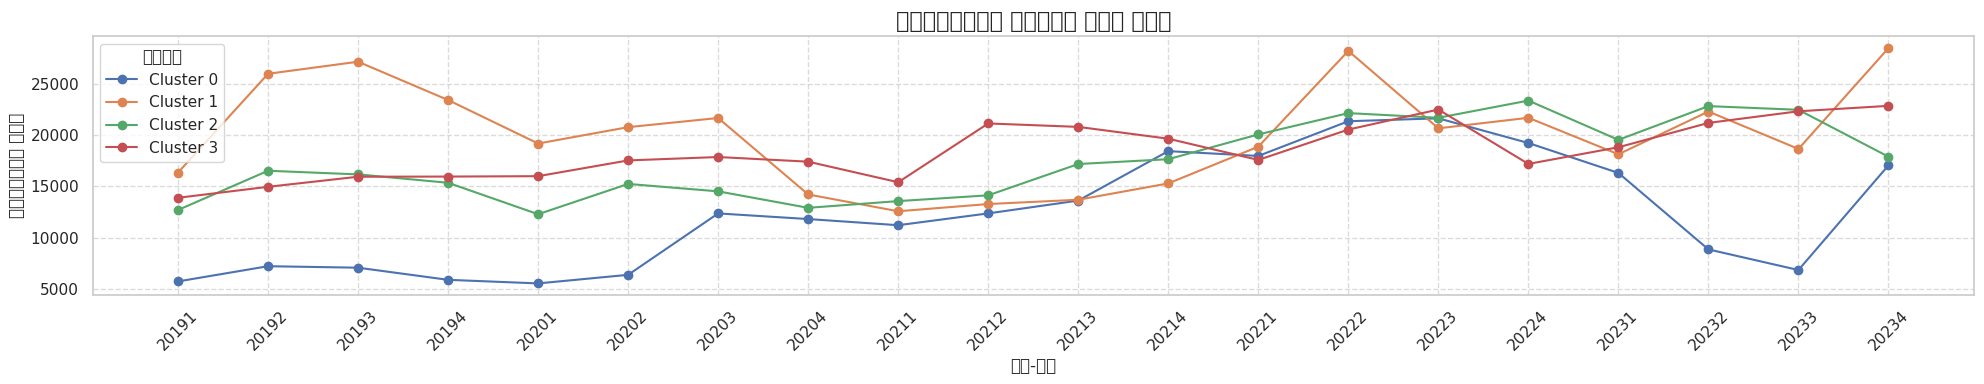

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

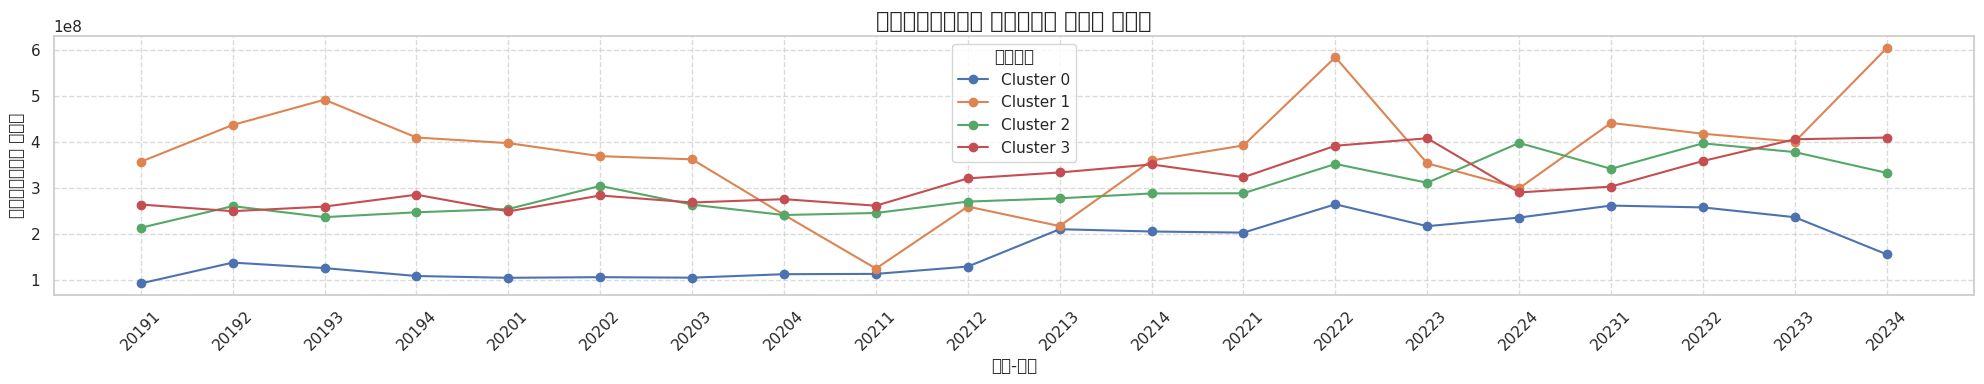

In [39]:
# 주말매출건수 금액 비교
pivot = help_me_median(target_df, '연령대20유동인구수')
pivot = help_me_median(target_df, '토요일매출건수')
pivot = help_me_median(target_df, '토요일매출금액')
pivot = help_me_median(target_df, '일요일매출건수')
pivot = help_me_median(target_df, '일요일매출금액')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

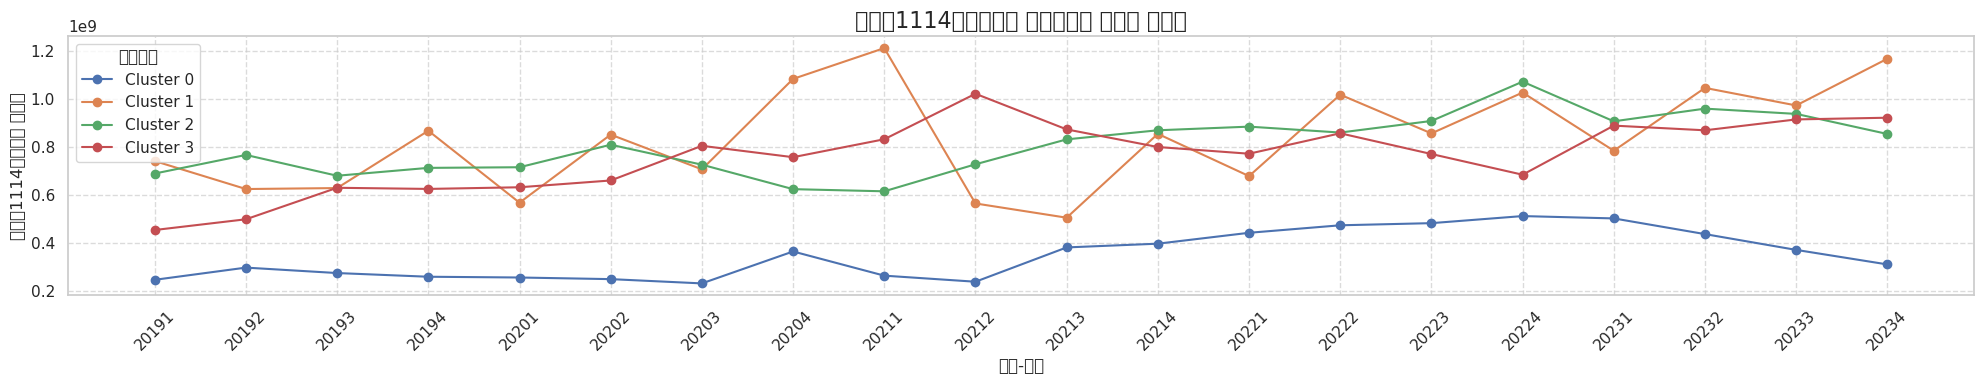

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

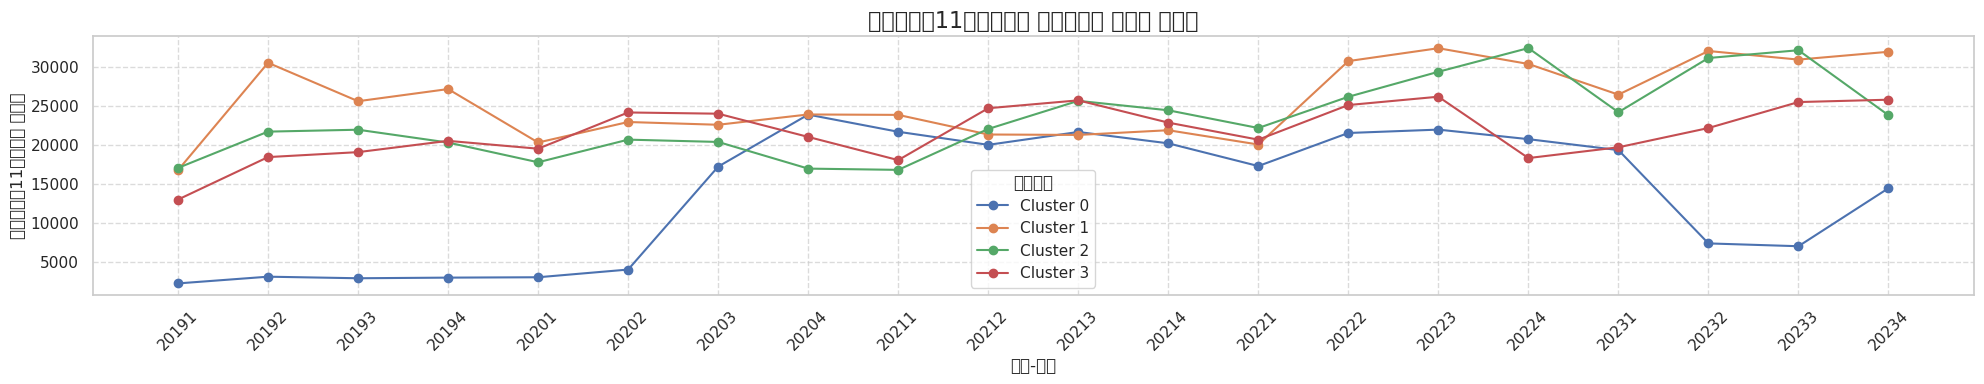

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

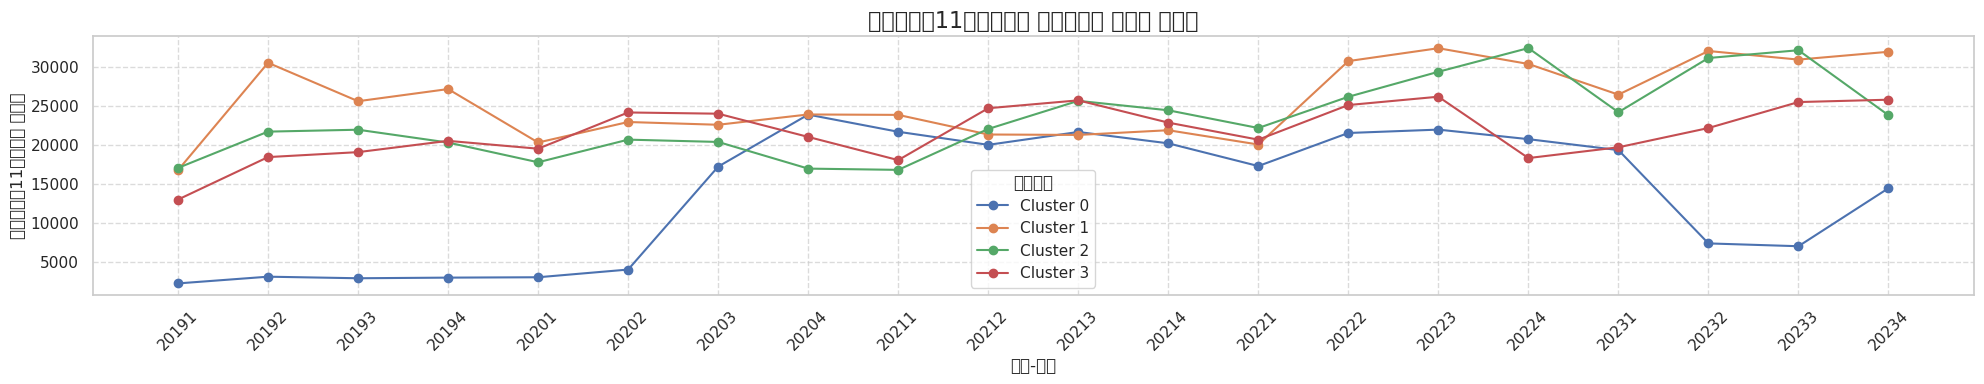

In [40]:
pivot = help_me_median(target_df, '시간대1114매출금액')
pivot = help_me_median(target_df, '시간대건수11매출건수')
pivot = help_me_median(target_df, '시간대건수11매출건수')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

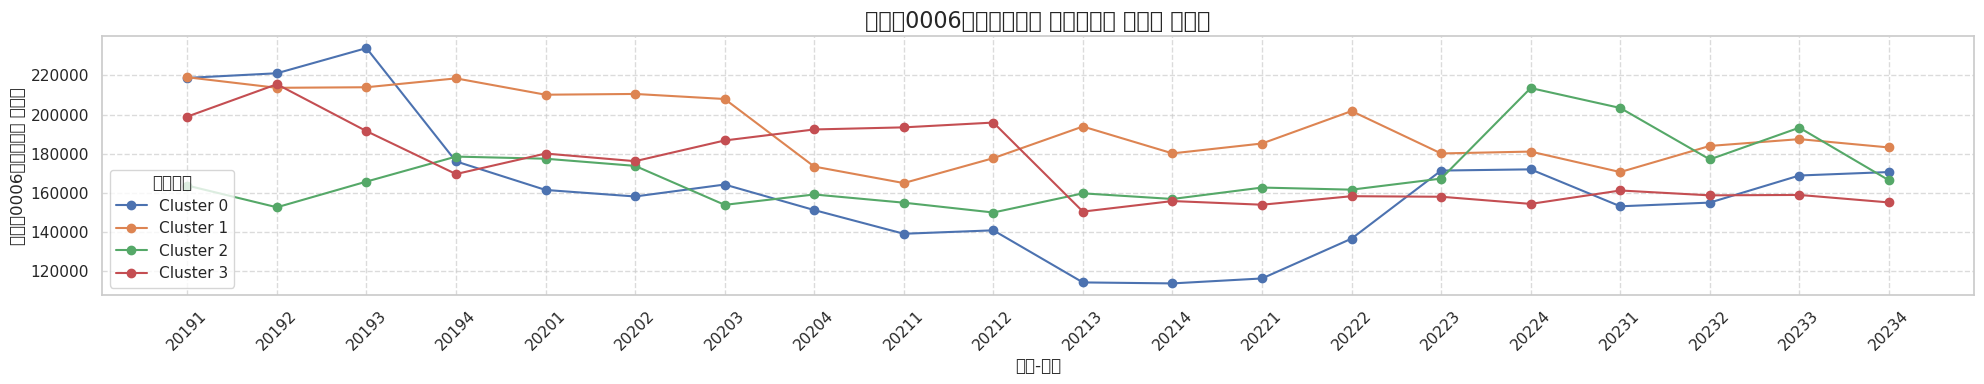

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

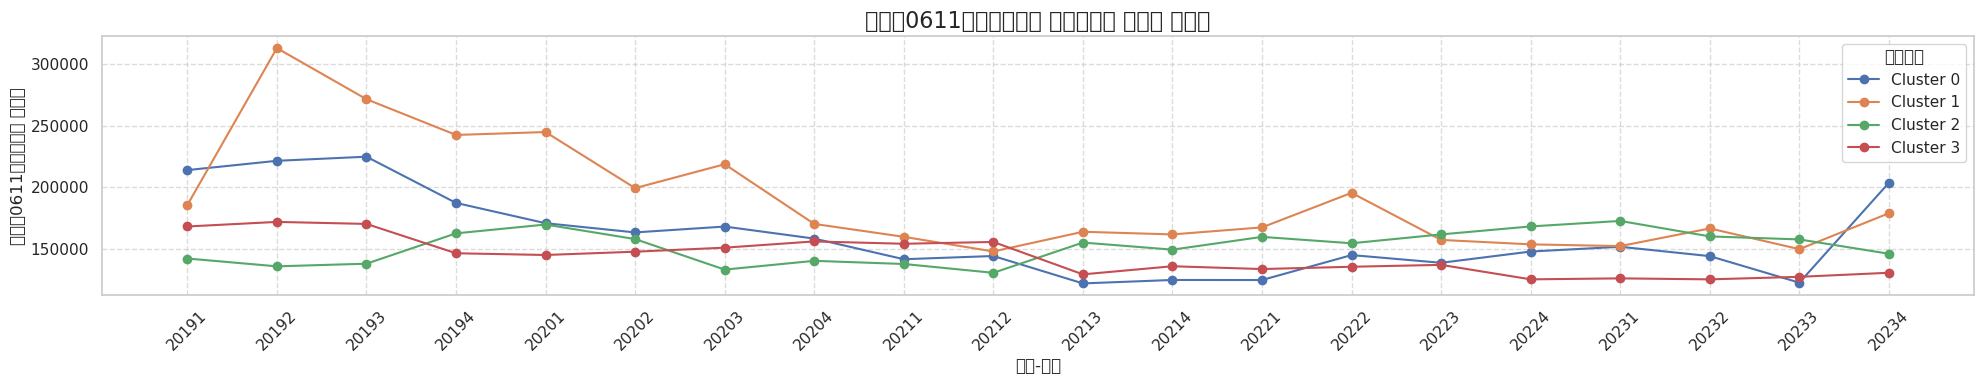

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

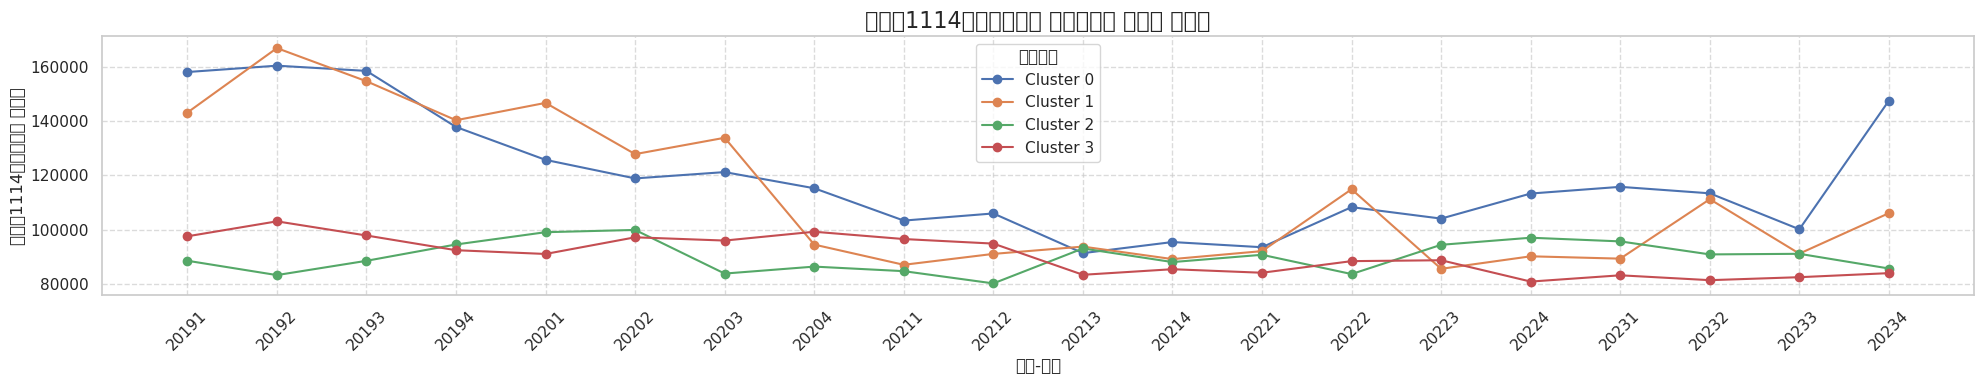

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

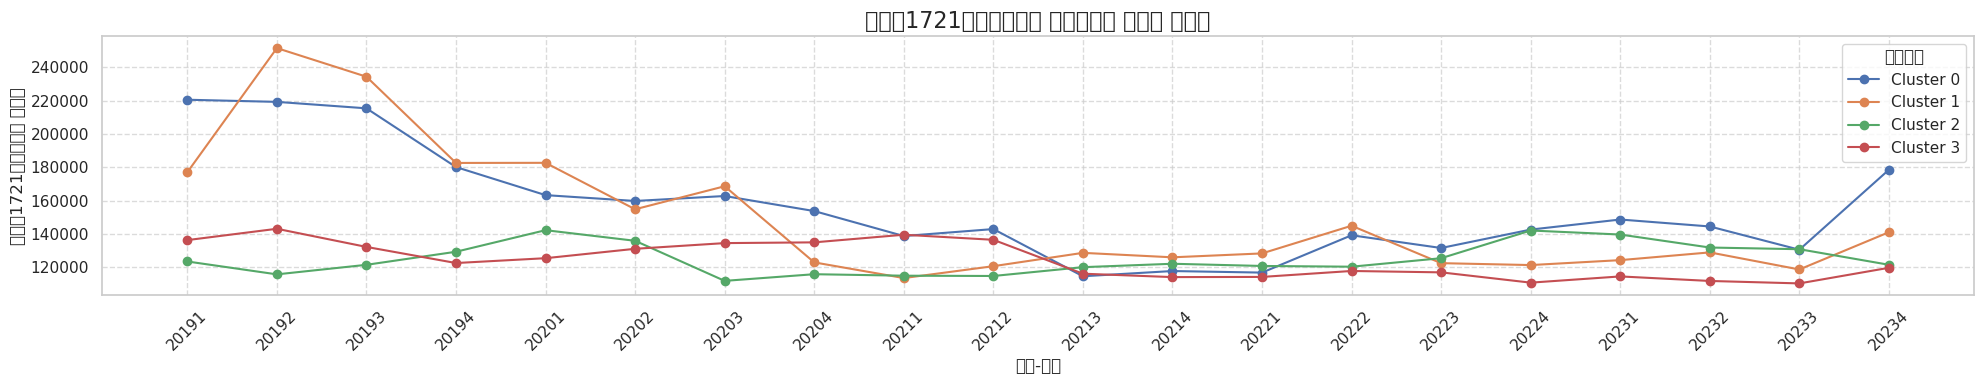

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

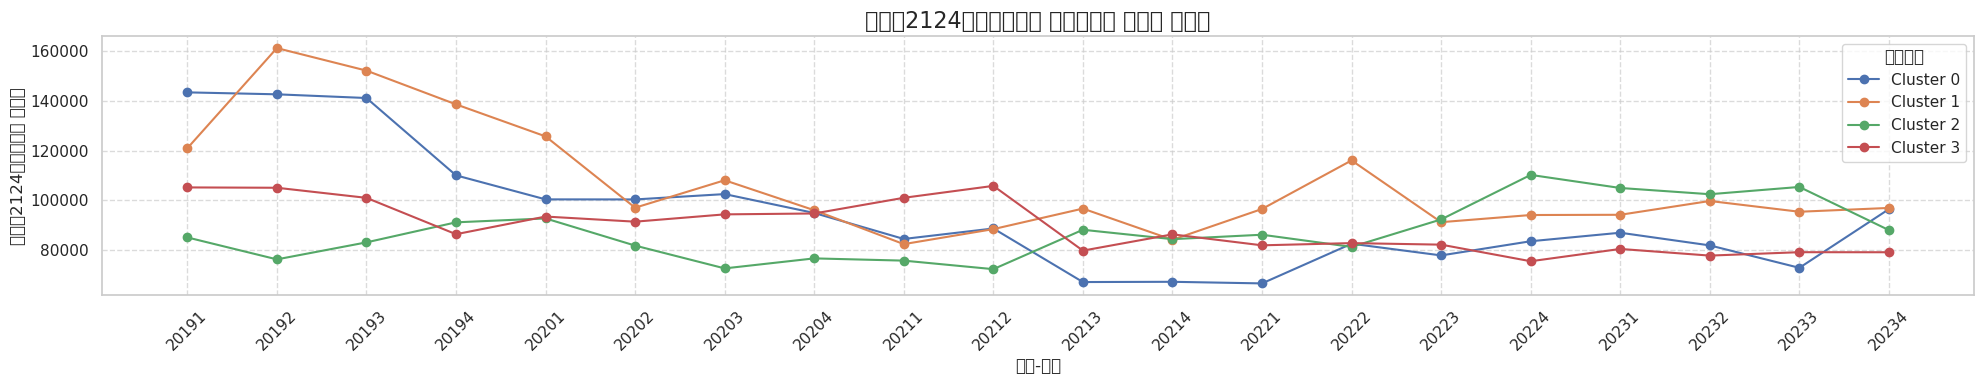

In [41]:
pivot = help_me_median(target_df, '시간대0006유동인구수')
pivot = help_me_median(target_df, '시간대0611유동인구수')
pivot = help_me_median(target_df, '시간대1114유동인구수')
pivot = help_me_median(target_df, '시간대1721유동인구수')
pivot = help_me_median(target_df, '시간대2124유동인구수')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

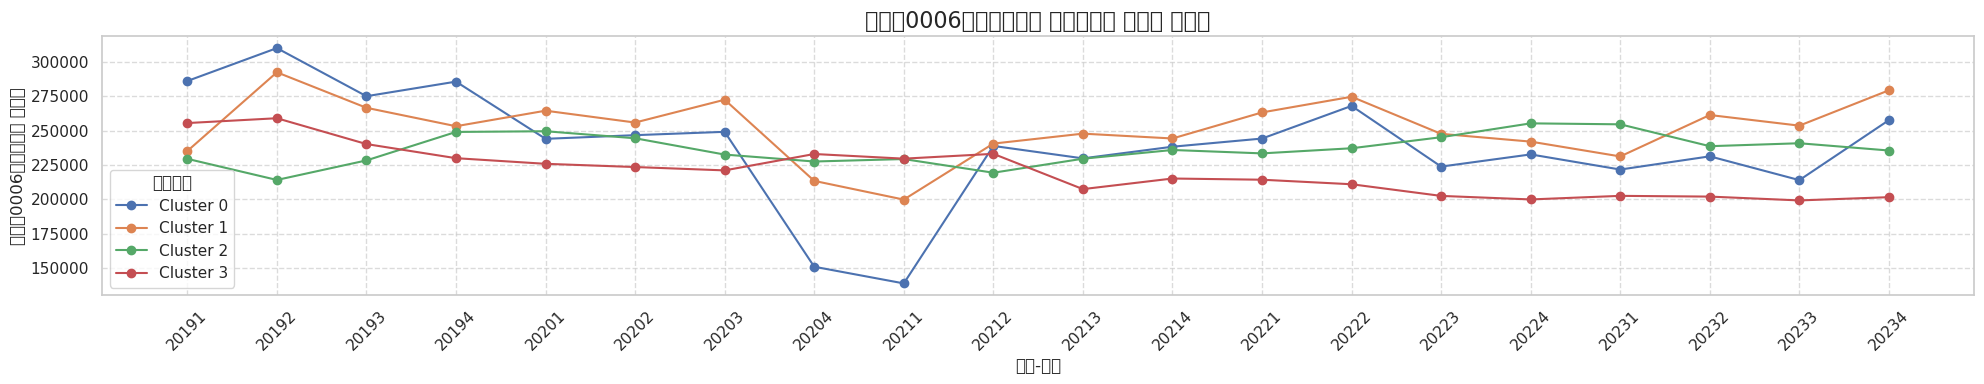

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

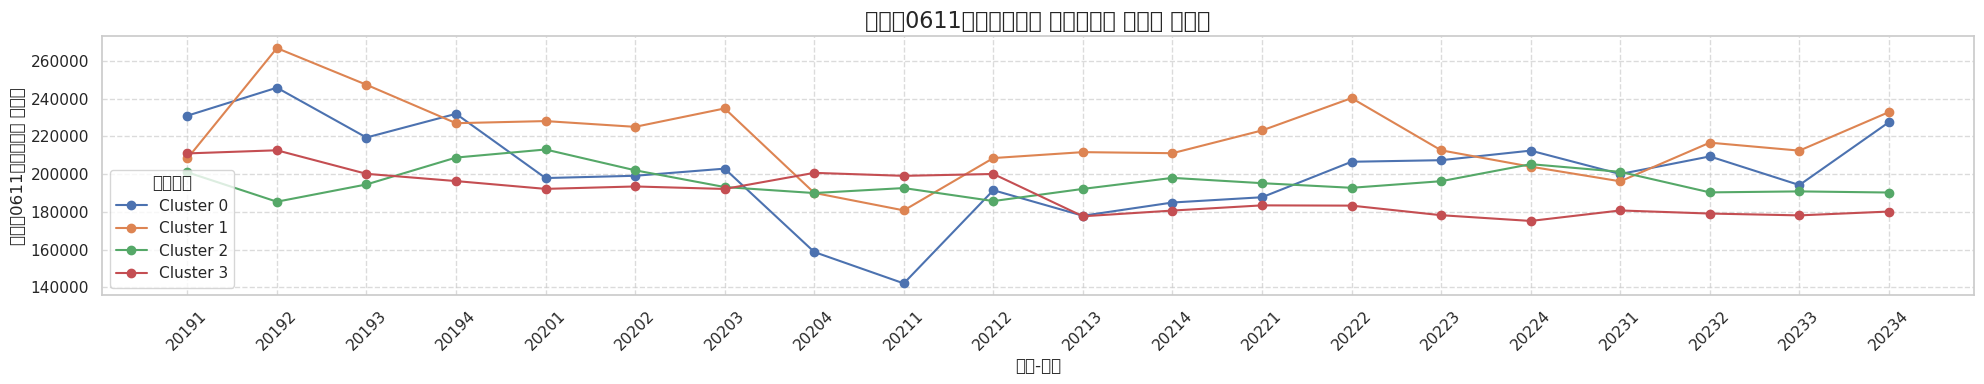

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

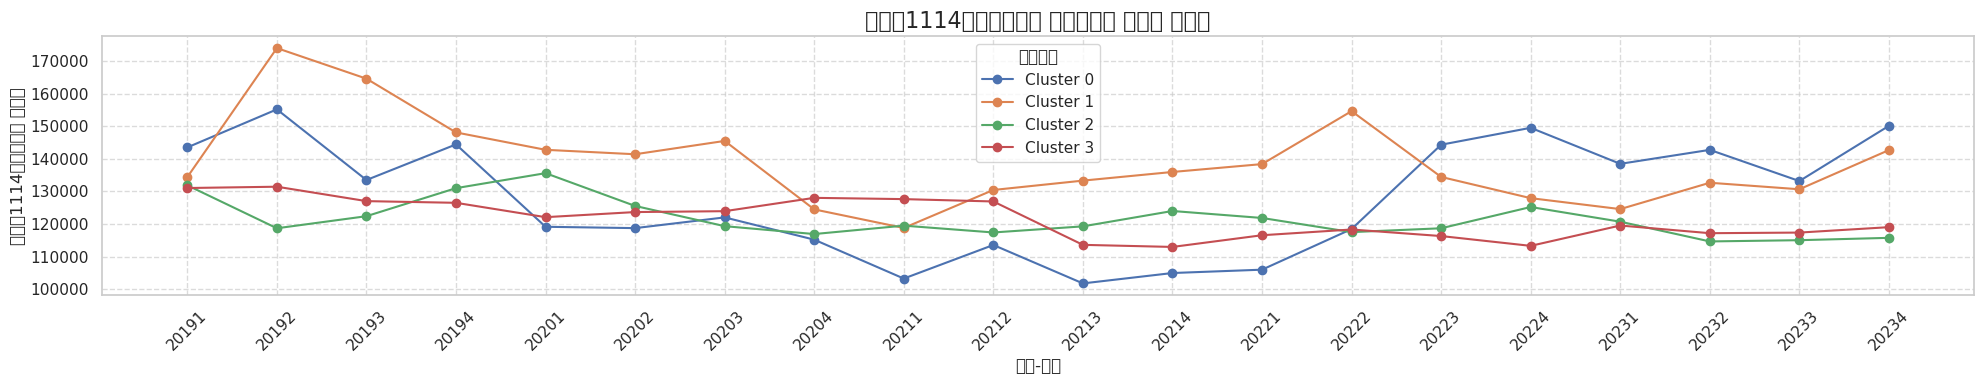

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

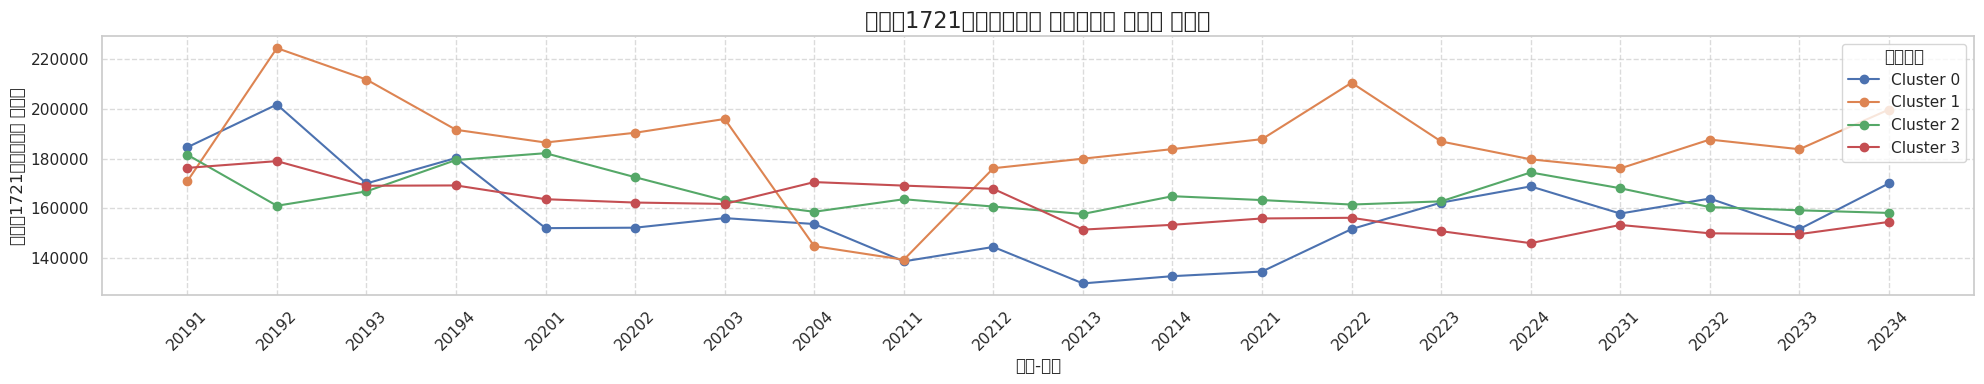

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

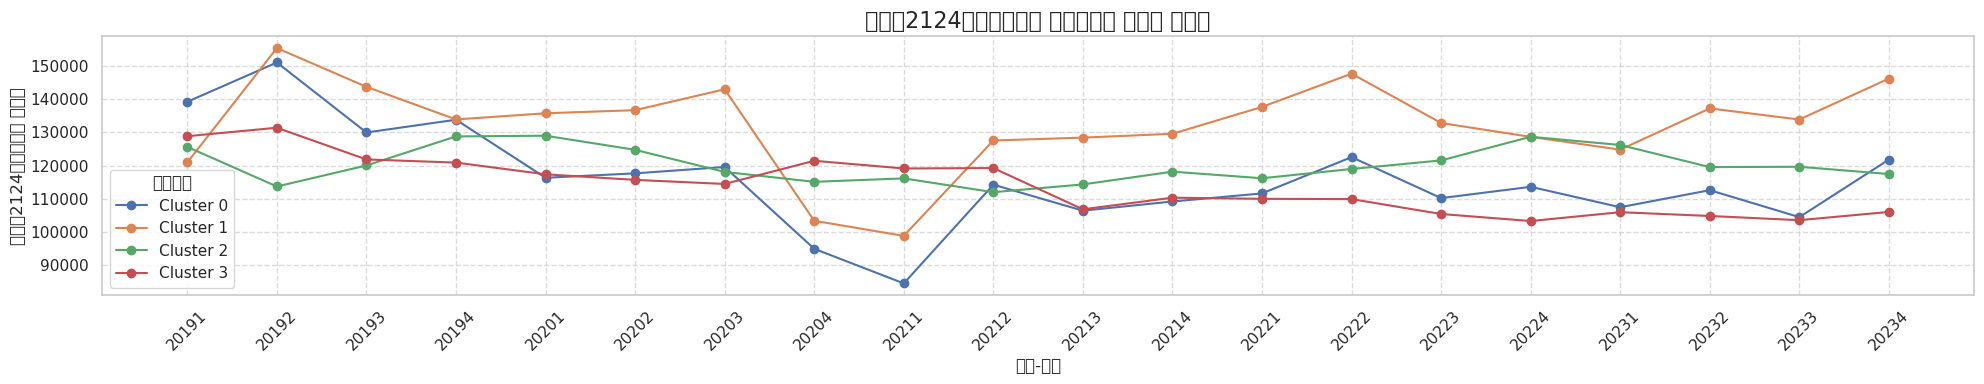

In [42]:
help_me_mean(target_df, '시간대0006유동인구수')
help_me_mean(target_df, '시간대0611유동인구수')
help_me_mean(target_df, '시간대1114유동인구수')
help_me_mean(target_df, '시간대1721유동인구수')
help_me_mean(target_df, '시간대2124유동인구수')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

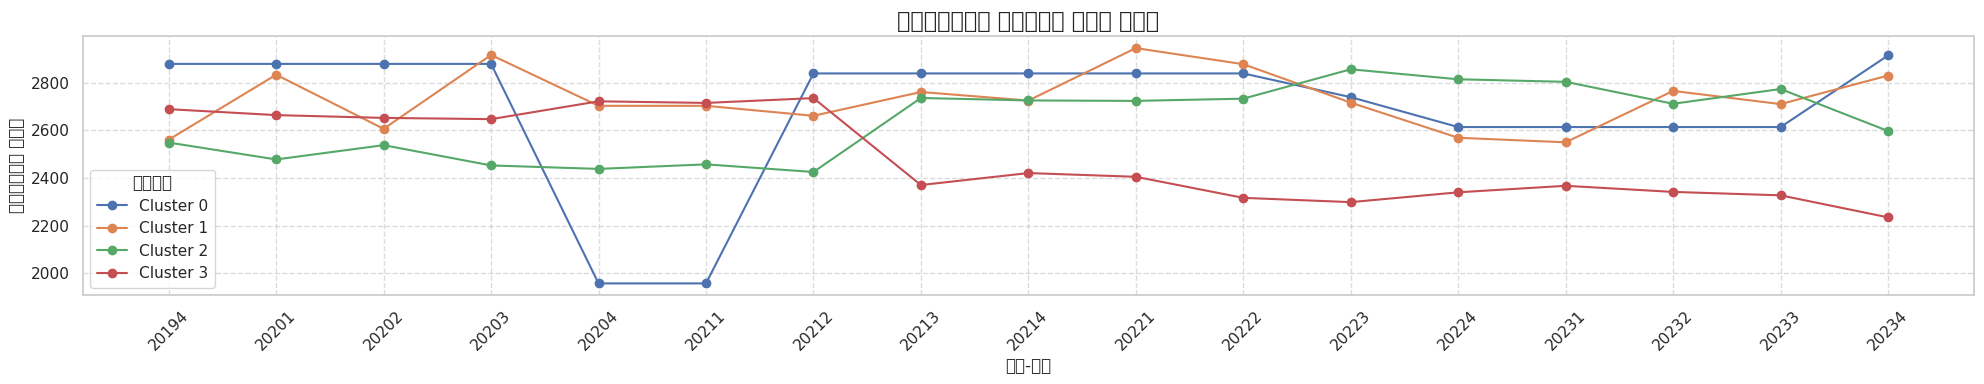

In [43]:
help_me_mean(target_df, '총상주인구수')